# Analyze data from education systems

In [1]:
from math import prod
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib .pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Methods cell

In [2]:
def df_initial_analysis(df, name_df):
    """
    Initial analysis on the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame. 
    """
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        
        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty columns:        ", len(empty_cols))
        print(" + The empty column is:          ", empty_cols) if len(empty_cols) == 1 \
            else (print(" + The empty column are:          ", empty_cols) if len(empty_cols) >= 1 else None)
        print("\n- Type object and records by columns")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))


def comparison_dfs(df_original, df_copy):
    """
    Create a DataFrame based on comparación between the original DataFrame and the copy DataFrame.
    Args:
        df_original (pandas.DataFrame): DataFrame original.
        df_copy (pandas.DataFrame): DataFrame copy.
    Returns:
        df_comparison (pandas.DataFrame): DataFrame comparison.
    """
    df_comparison = pd.DataFrame({
        "Moment" : ["Before", "After"],
        "Total values" : [prod(df_original.shape), prod(df_copy.shape)], 
        "Valid values" : [(prod(df_original.shape)-df_original.isna().sum().sum()), (prod(df_copy.shape)-df_copy.isna().sum().sum())],
        "Missing values" : [df_original.isna().sum().sum(), df_copy.isna().sum().sum()]
    })
    return df_comparison


def most_common_words(labels, quantity):
    """
    Split all words present in list and count how many times it
    is repeated in the list. 
    Args:
        labels (list): List of strings to split.
        quantity (int): Amount of most common words to return.
    Returns:
        counter (liste): List of words splitted with its number of ocurrences.
    """
    words = [i.split(" ", 1)[0] for i in labels]
    counter = Counter(words).most_common(quantity)
    df = pd.DataFrame(counter, columns=["Word", "Occurence number"])\
                        .sort_values(by="Occurence number", ascending=True)
    return df


def countries_by_year(df_vals):
    """
    Calculating the amount of countries by year.
    Args:
        df_vals (pandas.DataFrame): DataFrame to work.
    Returns:
        df (pandas.DataFrame): DataFrame with amount of countries by year.
    """    
    years_in_df, countries_by_years = [], []

    for col in df_vals.columns:
        if col !="Country Code":
            df_temp = pd.DataFrame(df_vals[[col, "Country Code"]].dropna(axis="rows", how="any"))
            years_in_df.append(df_vals[col].name)
            countries_by_years.append(df_temp["Country Code"].nunique())

    df = pd.DataFrame({
            "Year" : years_in_df,
            "Countries" : countries_by_years
    })

    return df


def remove_columns_by_percentage_of_nan_values(df):
    """
    Remove columns in DataFrame based on percentage of NaN values in columns.
    Args:
        df (pandas.DataFrame): DataFrame to work.
    Returns:
        df (pandas.DataFrame): DataFrame worked.
    """
    percentage = 50 # Removing columns with more than 50% NaN values 

    for col in df.columns:
        if round(((df.shape[0] - df[col].count()) / df.shape[0]) * 100, 2) > percentage:
            print("- The column",  df[col].name, "has been removed.")
            df.drop([col], axis=1, inplace=True)

    return df

## Loading data

In [3]:
# loading Dataset and removing the empty columns (the empty columns, unnamed, etc.)
country = pd.read_csv("datasets/EdStatsCountry.csv")
serie = pd.read_csv("datasets/EdStatsSeries.csv")
country_serie = pd.read_csv("datasets/EdStatsCountry-Series.csv")
foot_note = pd.read_csv("datasets/EdStatsFootNote.csv")
data = pd.read_csv("datasets/EdStatsData.csv")

## Initial data analysis
- Knowing the entities of the datasets.<br>

    - **Country** dataset **`"EdStatsCountry.csv"`**.<br>
    Des renseignements en général sur l'économie de chaque pays du monde.
    
    - **Serie** dataset **`"EdStatsSeries.csv"`**.<br>
    Des renseignements en peu plus de détails sur les indicateurs économiques.
    
    - **Country-Serie** dataset **`"EdStatsCountry-Series.csv"`**.<br>
    La source des données sur l'information relationnelle entre **`"EdStatsCountry.csv"`** et **`"EdStatsSeries.csv"`**.

    - **Foot Note** dataset **`"EdStatsFootNote.csv"`**.<br>
    L’année d’origine des données et aussi une description sur les indicateurs.

    - **Data** dataset **`"EdStatsData.csv"`**.<br>
    Le dataset principal qui contient en détails le renseignement sur les indicateurs par an.

- Entity relationship diagram.<br>
<br>Il existe une relation **"virtuel"** entre les datasets via les colonnes **`"Country Code"`** et **`"Series Code"`** principalement.<br>
_**Il faut rester prudent avec ces relations**_.<br>
![Entity relationship diagram](img/entity_relationship.png)

### **`"Country"`** dataset

In [4]:
country.head(3)

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   
2  April 2013 database update: Based on IMF data,...   

                      Region          Income Group WB-2 code  ...  \
0  Latin America & Caribbean  High income: nonOECD        AW  ...   
1                 South Asia            Low income        AF  ...   
2         Sub-Saharan Africa   Upper middle income        AO  ...   

            IMF data dissemination standard  Latest population census  \
0                                       NaN                      2010   
1  General Data Dissemination System (GDDS)                      1979   
2  General Data Dissemination System (GDDS)                      1970   

                             Latest household survey  \
0                                                NaN   
1  Multiple Indicator Cluster Survey (MICS), 2010/11   
2               Malaria Indicator Survey (MIS), 2011   

  Source of most recent Income and expenditure data  \
0                                               NaN   
1           Integrated household survey (IHS), 2008   
2           Integrated household survey (IHS), 2008   

  Vital registration complete Latest agricultural census  \
0                         Yes                        NaN   
1                         NaN                    2013/14   
2                         NaN                       2015   

  Latest industrial data Latest trade data Latest water withdrawal data  \
0                    NaN            2012.0                          NaN   
1                    NaN            2012.0                         2000   
2                    NaN               NaN                         2005   

  Unnamed: 31  
0         NaN  
1         NaN  
2         NaN  

[3 rows x 32 columns]

In [5]:
# Describing the numeric columns
country.describe()

National accounts reference year  Latest industrial data  \
count                          32.00000              107.000000   
mean                         2001.53125             2008.102804   
std                             5.24856                2.616834   
min                          1987.00000             2000.000000   
25%                          1996.75000             2007.500000   
50%                          2002.00000             2009.000000   
75%                          2005.00000             2010.000000   
max                          2012.00000             2010.000000   

       Latest trade data  Unnamed: 31  
count         185.000000          0.0  
mean         2010.994595          NaN  
std             2.569675          NaN  
min          1995.000000          NaN  
25%          2011.000000          NaN  
50%          2012.000000          NaN  
75%          2012.000000          NaN  
max          2012.000000          NaN

In [6]:
# Resume of dataset
df_initial_analysis(country, "country")


Initial Analysis of country dataset
--------------------------------------------------------------------------
- Dataset shape:                  241 rows and 32 columns
- Total of NaN values:            2354
- Percentage of NaN:              30.52 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 31']

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      241
3                                           Long Name   object      241
1                                          Short Name   object      241
2                                          Table Name   object      241
9                                           WB-2 code   object      240
4                                        2-alpha code   object      238
5         

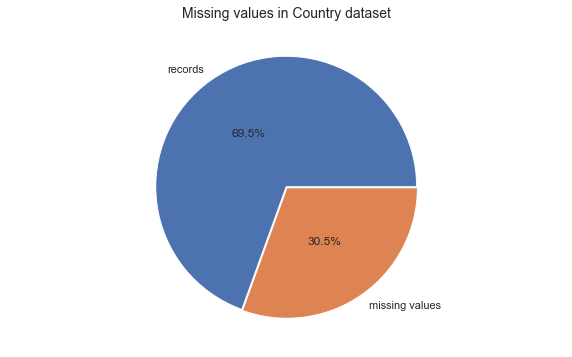

In [7]:
# Drawing missing values in Country dataset
labels = ["records", "missing values"]
vals = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country dataset", fontsize=14)
plt.show()

### **`"Serie"`** dataset

In [8]:
serie.head(3)

Series Code       Topic  \
0  BAR.NOED.1519.FE.ZS  Attainment   
1     BAR.NOED.1519.ZS  Attainment   
2  BAR.NOED.15UP.FE.ZS  Attainment   

                                      Indicator Name  \
0  Barro-Lee: Percentage of female population age...   
1  Barro-Lee: Percentage of population age 15-19 ...   
2  Barro-Lee: Percentage of female population age...   

                                    Short definition  \
0  Percentage of female population age 15-19 with...   
1  Percentage of population age 15-19 with no edu...   
2  Percentage of female population age 15+ with n...   

                                     Long definition  Unit of measure  \
0  Percentage of female population age 15-19 with...              NaN   
1  Percentage of population age 15-19 with no edu...              NaN   
2  Percentage of female population age 15+ with n...              NaN   

  Periodicity Base Period Other notes Aggregation method  ...  \
0         NaN         NaN         NaN                NaN  ...   
1         NaN         NaN         NaN                NaN  ...   
2         NaN         NaN         NaN                NaN  ...   

  Notes from original source  General comments  \
0                        NaN               NaN   
1                        NaN               NaN   
2                        NaN               NaN   

                                              Source  \
0  Robert J. Barro and Jong-Wha Lee: http://www.b...   
1  Robert J. Barro and Jong-Wha Lee: http://www.b...   
2  Robert J. Barro and Jong-Wha Lee: http://www.b...   

  Statistical concept and methodology Development relevance  \
0                                 NaN                   NaN   
1                                 NaN                   NaN   
2                                 NaN                   NaN   

  Related source links Other web links  Related indicators  License Type  \
0                  NaN             NaN                 NaN           NaN   
1                  NaN             NaN                 NaN           NaN   
2                  NaN             NaN                 NaN           NaN   

   Unnamed: 20  
0          NaN  
1          NaN  
2          NaN  

[3 rows x 21 columns]

In [9]:
# Describing the numeric columns
serie.describe()

Unit of measure  Notes from original source  Other web links  \
count              0.0                         0.0              0.0   
mean               NaN                         NaN              NaN   
std                NaN                         NaN              NaN   
min                NaN                         NaN              NaN   
25%                NaN                         NaN              NaN   
50%                NaN                         NaN              NaN   
75%                NaN                         NaN              NaN   
max                NaN                         NaN              NaN   

       Related indicators  License Type  Unnamed: 20  
count                 0.0           0.0          0.0  
mean                  NaN           NaN          NaN  
std                   NaN           NaN          NaN  
min                   NaN           NaN          NaN  
25%                   NaN           NaN          NaN  
50%                   NaN           NaN          NaN  
75%                   NaN           NaN          NaN  
max                   NaN           NaN          NaN

In [10]:
# Resume of dataset
df_initial_analysis(serie, "serie")


Initial Analysis of serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  3665 rows and 21 columns
- Total of NaN values:            55203
- Percentage of NaN:              71.72 %
- Total of full duplicates rows:  0
- Total of empty columns:         6
 + The empty column are:           ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

- Type object and records by columns
--------------------------------------------------------------------------
                                   Name     Type  Records
0                           Series Code   object     3665
13                               Source   object     3665
2                        Indicator Name   object     3665
4                       Long definition   object     3665
1                                 Topic   object     3665
3                      Short definition   object     2156
8

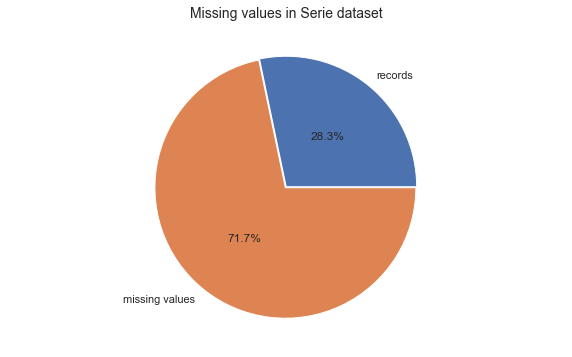

In [11]:
# Drawing missing values in Serie dataset
labels = ["records", "missing values"]
vals = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Serie dataset", fontsize=14)
plt.show()

### **`"Country-Serie"`** dataset

In [12]:
country_serie.head(3)

CountryCode   SeriesCode                                        DESCRIPTION  \
0         ABW  SP.POP.TOTL  Data sources : United Nations World Population...   
1         ABW  SP.POP.GROW  Data sources: United Nations World Population ...   
2         AFG  SP.POP.GROW  Data sources: United Nations World Population ...   

   Unnamed: 3  
0         NaN  
1         NaN  
2         NaN

In [13]:
# Resume of dataset
df_initial_analysis(country_serie, "country_serie")


Initial Analysis of country_serie dataset
--------------------------------------------------------------------------
- Dataset shape:                  613 rows and 4 columns
- Total of NaN values:            613
- Percentage of NaN:              25.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 3']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object      613
1   SeriesCode   object      613
2  DESCRIPTION   object      613
3   Unnamed: 3  float64        0


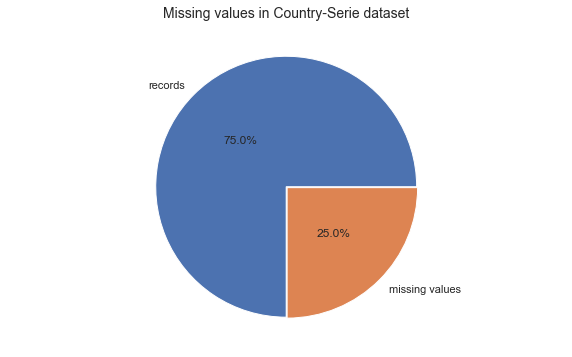

In [14]:
# Drawing missing values in Country-Serie dataset
labels = ["records", "missing values"]
vals = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Country-Serie dataset", fontsize=14)
plt.show()

### **`"Foot Note"`** dataset

In [15]:
foot_note.head(3)

CountryCode      SeriesCode    Year          DESCRIPTION  Unnamed: 4
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.         NaN
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.         NaN
2         ABW  SE.PRE.TCHR.FE  YR2000  Country estimation.         NaN

In [16]:
# Describing the numeric columns
foot_note.describe()

Unnamed: 4
count         0.0
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN

In [17]:
# Resume of dataset
df_initial_analysis(foot_note, "foot_note")


Initial Analysis of foot_note dataset
--------------------------------------------------------------------------
- Dataset shape:                  643638 rows and 5 columns
- Total of NaN values:            643638
- Percentage of NaN:              20.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 4']

- Type object and records by columns
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object   643638
1   SeriesCode   object   643638
2         Year   object   643638
3  DESCRIPTION   object   643638
4   Unnamed: 4  float64        0


In [18]:
# Drawing missing values in Foot Note dataset
labels = ["records", "missing values"]
vals = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Foot-Note dataset", fontsize=14)
plt.show()

### **`"Data"`** dataset

In [19]:
data.head(3)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   

                                      Indicator Name  Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   NaN   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   NaN   

   1971  1972  1973  1974  1975  ...  2060  2065  2070  2075  2080  2085  \
0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2090  2095  2100  Unnamed: 69  
0   NaN   NaN   NaN          NaN  
1   NaN   NaN   NaN          NaN  
2   NaN   NaN   NaN          NaN  

[3 rows x 70 columns]

In [20]:
# Describing the numeric columns
data.describe()

1970          1971          1972          1973          1974  \
count  7.228800e+04  3.553700e+04  3.561900e+04  3.554500e+04  3.573000e+04   
mean   1.974772e+09  4.253638e+09  4.592365e+09  5.105006e+09  5.401493e+09   
std    1.211687e+11  1.804814e+11  1.914083e+11  2.059170e+11  2.112150e+11   
min   -1.435564e+00 -1.594625e+00 -3.056522e+00 -4.032582e+00 -4.213563e+00   
25%    8.900000e-01  8.853210e+00  9.240920e+00  9.595200e+00  9.861595e+00   
50%    6.317724e+00  6.316240e+01  6.655139e+01  6.969595e+01  7.087760e+01   
75%    6.251250e+01  5.655200e+04  5.863650e+04  6.202900e+04  6.383675e+04   
max    1.903929e+13  1.986457e+13  2.100916e+13  2.238367e+13  2.282991e+13   

               1975          1976          1977          1978          1979  \
count  8.730600e+04  3.748300e+04  3.757400e+04  3.757600e+04  3.680900e+04   
mean   2.314288e+09  5.731808e+09  6.124437e+09  6.671489e+09  7.436724e+09   
std    1.375059e+11  2.215546e+11  2.325489e+11  2.473986e+11  2.660957e+11   
min   -3.658569e+00 -2.950945e+00 -3.174870e+00 -3.558749e+00 -2.973612e+00   
25%    1.400000e+00  9.312615e+00  9.519913e+00  1.000000e+01  1.000000e+01   
50%    9.677420e+00  7.101590e+01  7.133326e+01  7.290512e+01  7.510173e+01   
75%    7.854163e+01  5.682800e+04  5.739175e+04  5.940425e+04  6.411500e+04   
max    2.300634e+13  2.424128e+13  2.521383e+13  2.622101e+13  2.730873e+13   

       ...          2060          2065          2070          2075  \
count  ...  5.143600e+04  5.143600e+04  5.143600e+04  5.143600e+04   
mean   ...  7.224868e+02  7.271290e+02  7.283779e+02  7.266484e+02   
std    ...  2.215845e+04  2.287990e+04  2.352338e+04  2.408149e+04   
min    ... -1.630000e+00 -1.440000e+00 -1.260000e+00 -1.090000e+00   
25%    ...  3.000000e-02  3.000000e-02  2.000000e-02  2.000000e-02   
50%    ...  2.300000e-01  2.300000e-01  2.300000e-01  2.300000e-01   
75%    ...  7.505000e+00  7.500000e+00  7.300000e+00  7.100000e+00   
max    ...  2.951569e+06  3.070879e+06  3.169711e+06  3.246239e+06   

               2080          2085          2090          2095          2100  \
count  5.143600e+04  5.143600e+04  5.143600e+04  5.143600e+04  5.143600e+04   
mean   7.228327e+02  7.176899e+02  7.113072e+02  7.034274e+02  6.940296e+02   
std    2.455897e+04  2.496587e+04  2.530183e+04  2.556069e+04  2.574189e+04   
min   -9.200000e-01 -7.800000e-01 -6.500000e-01 -5.500000e-01 -4.500000e-01   
25%    1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02  1.000000e-02   
50%    2.300000e-01  2.300000e-01  2.300000e-01  2.300000e-01  2.200000e-01   
75%    6.722500e+00  6.080000e+00  5.462500e+00  4.680000e+00  4.032500e+00   
max    3.301586e+06  3.337871e+06  3.354746e+06  3.351887e+06  3.330484e+06   

       Unnamed: 69  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN  

[8 rows x 66 columns]

In [21]:
# Resume of dataset
df_initial_analysis(data, "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  886930 rows and 70 columns
- Total of NaN values:            53455179
- Percentage of NaN:              86.1 %
- Total of full duplicates rows:  0
- Total of empty columns:         1
 + The empty column is:           ['Unnamed: 69']

- Type object and records by columns
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   886930
2   Indicator Name   object   886930
3   Indicator Code   object   886930
1     Country Code   object   886930
44            2010  float64   242442
..             ...      ...      ...
7             1973  float64    35545
5             1971  float64    35537
50            2016  float64    16460
51            2017  float64      143
69     Unnamed: 69  float64        0

[70 rows x 3 columns]


In [22]:
# Drawing missing values in Data dataset
labels = ["records", "missing values"]
vals = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
explode = (0, 0.01)

pie, ax = plt.subplots(figsize=[10,6])
plt.axis("equal")
plt.pie(x=vals, labels=labels, explode=explode,  autopct="%.1f%%", pctdistance=0.5)
plt.title("Missing values in Data dataset", fontsize=14)
plt.show()

## Data cleanup
- Creating copies from all datasets.
- Deleting empty columns and empty rows.
- Filtring **all datasets** based on list of **`"countries"`** as given in **`"ISO 3166-1"`** .<br> 
    - **`"EdStatsCountry"`** is going to be the pivot to filter the others datasets.<br>
        - To **`"EdStatsSeries"`** the pivots are going to be **`"EdStatsCountry"`** and **`"EdStatsData"`**.<br>
    - List of **`"countries"`** as given in **`"ISO 3166-1"`** and the corresponding **`"ISO 3166-1-alpha-2"`** code elements.<br>https://datahub.io/core/country-list#resource-data 

### Loading data and removing empty columns and empty rows

In [23]:
country_copy = country.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
serie_copy = serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
country_serie_copy = country_serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
foot_note_copy = foot_note.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
data_copy = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

### Comparing datasets before and after removing empty columns/rows

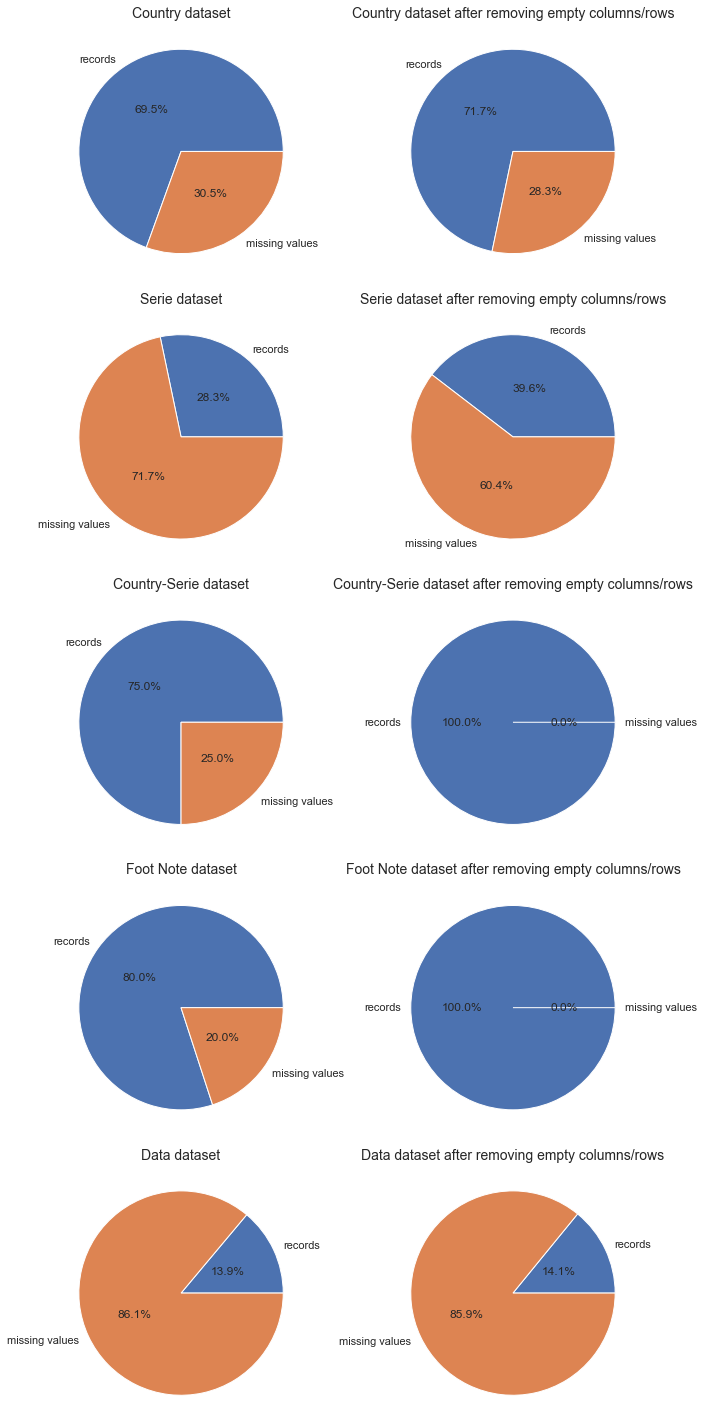

In [24]:
# Comparing missing values in all datasets before and after removing empty columns/rows
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after removing empty columns/rows", fontsize=14)

vals_ax3 = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
ax3.pie(x=vals_ax3, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax3.set_title("Serie dataset", fontsize=14)

vals_ax4 = [prod(serie_copy.shape)-serie_copy.isna().sum().sum(), serie_copy.isna().sum().sum()]
ax4.pie(x=vals_ax4, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax4.set_title("Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax5 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax5.pie(x=vals_ax5, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax5.set_title("Country-Serie dataset", fontsize=14)

vals_ax6 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax6.pie(x=vals_ax6, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax6.set_title("Country-Serie dataset after removing empty columns/rows", fontsize=14)

vals_ax7 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax7.pie(x=vals_ax7, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax7.set_title("Foot Note dataset", fontsize=14)

vals_ax8 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax8.pie(x=vals_ax8, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax8.set_title("Foot Note dataset after removing empty columns/rows", fontsize=14)

vals_ax9 = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
ax9.pie(x=vals_ax9, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax9.set_title("Data dataset", fontsize=14)

vals_ax10 = [prod(data_copy.shape)-data_copy.isna().sum().sum(), data_copy.isna().sum().sum()]
ax10.pie(x=vals_ax10, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax10.set_title("Data dataset after removing empty columns/rows", fontsize=14)

plt.tight_layout()
plt.show()

### Comparing **`"Country"`** dataset before and after removing empty columns/rows

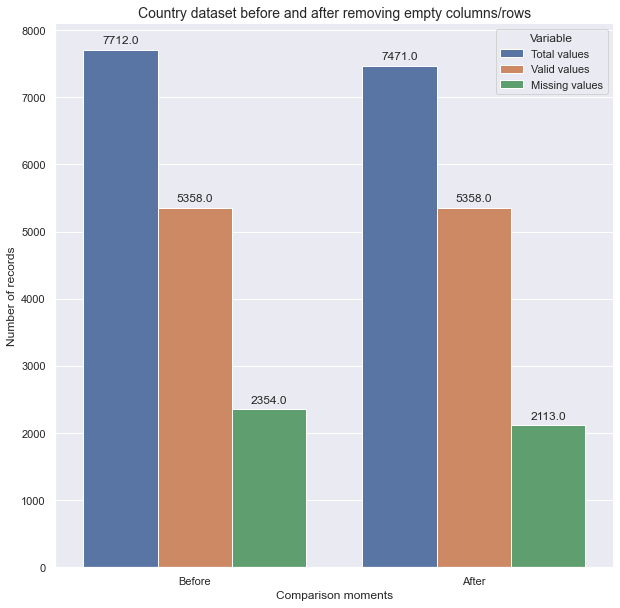

In [25]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Serie"`** dataset before and after removing empty columns/rows

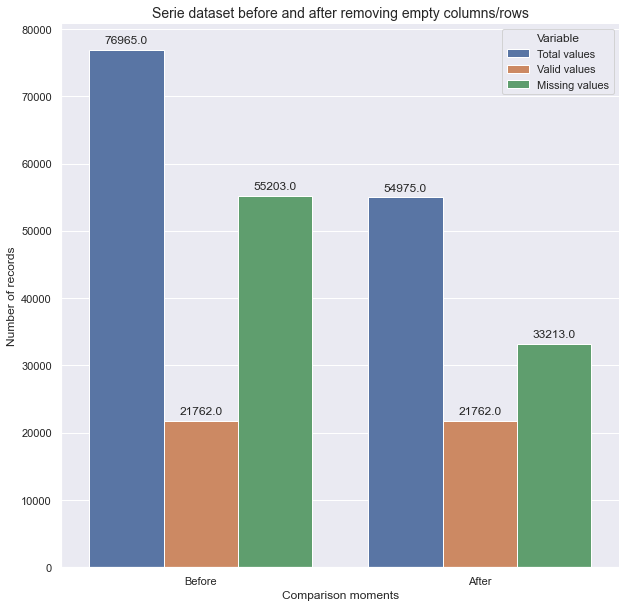

In [26]:
df_comparison = comparison_dfs(serie, serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Country-Serie"`** dataset before and after removing empty columns/rows

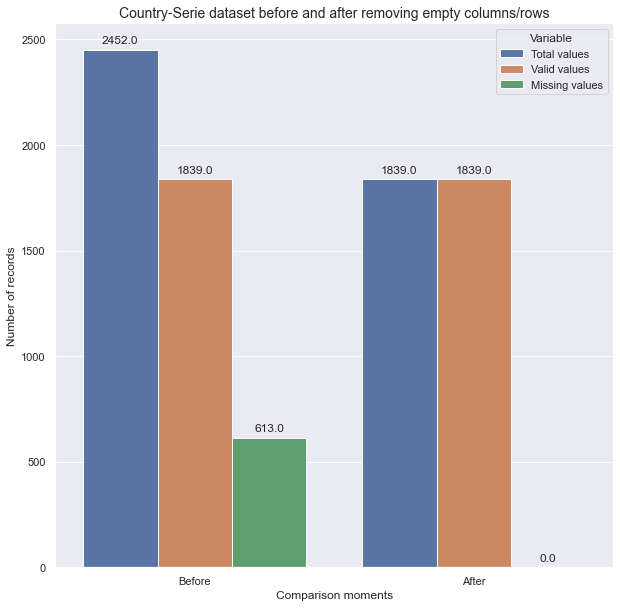

In [27]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Serie dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"FootNote"`** dataset before and after removing empty columns/rows

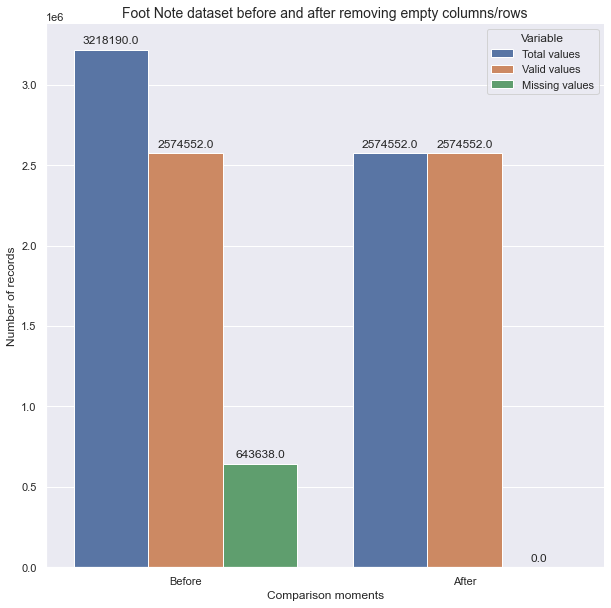

In [28]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Comparing **`"Data"`** dataset before and after removing empty columns/rows

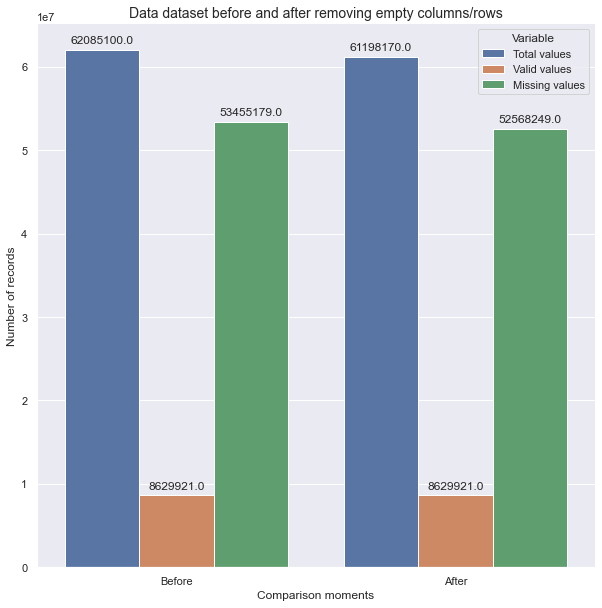

In [29]:
df_comparison = comparison_dfs(data, data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

### Cleaning **`"Country"`** dataset

In [30]:
# List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements.  
countries_iso = pd.read_csv("datasets/countries_ISO.csv", sep=",", 
                            keep_default_na=False, encoding="utf-8") # Avoiding that "NA" will be interpreted as NaN by Pandas

In [31]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_copy[~country_copy["2-alpha code"].isin(countries_iso["Code"])]
df_print

Country Code                                      Short Name  \
5            ARB                                      Arab World   
35           CHI                                 Channel Islands   
57           EAP           East Asia & Pacific (developing only)   
58           EAS         East Asia & Pacific (all income levels)   
59           ECA         Europe & Central Asia (developing only)   
60           ECS       Europe & Central Asia (all income levels)   
63           EMU                                       Euro area   
68           EUU                                  European Union   
89           HIC                                     High income   
92           HPC          Heavily indebted poor countries (HIPC)   
116          LAC     Latin America & Caribbean (developing only)   
122          LCN   Latin America & Caribbean (all income levels)   
123          LDC    Least developed countries: UN classification   
124          LIC                                      Low income   
127          LMC                             Lower middle income   
128          LMY                             Low & middle income   
140          MEA  Middle East & North Africa (all income levels)   
143          MIC                                   Middle income   
148          MNA    Middle East & North Africa (developing only)   
157          NAC                                   North America   
158          NAM                                         Namibia   
168          OED                                    OECD members   
187          SAS                                      South Asia   
198          SSA            Sub-Saharan Africa (developing only)   
200          SSF          Sub-Saharan Africa (all income levels)   
225          UMC                             Upper middle income   
234          WLD                                           World   
236          XKX                                          Kosovo   

                                         Table Name  \
5                                        Arab World   
35                                  Channel Islands   
57                              East Asia & Pacific   
58          East Asia & Pacific (all income levels)   
59                            Europe & Central Asia   
60        Europe & Central Asia (all income levels)   
63                                        Euro area   
68                                   European Union   
89                                      High income   
92           Heavily indebted poor countries (HIPC)   
116                       Latin America & Caribbean   
122   Latin America & Caribbean (all income levels)   
123    Least developed countries: UN classification   
124                                      Low income   
127                             Lower middle income   
128                             Low & middle income   
140  Middle East & North Africa (all income levels)   
143                                   Middle income   
148                      Middle East & North Africa   
157                                   North America   
158                                         Namibia   
168                                    OECD members   
187                                      South Asia   
198                              Sub-Saharan Africa   
200          Sub-Saharan Africa (all income levels)   
225                             Upper middle income   
234                                           World   
236                                          Kosovo   

                                          Long Name 2-alpha code  \
5                                        Arab World           1A   
35                                  Channel Islands          NaN   
57            East Asia & Pacific (developing only)           4E   
58          East Asia & Pacific (all income levels)           Z4   
59          Europe & Central Asia (developing only)           7E   
60        Europe & Central 

In [32]:
# Filter "EdStatsCountry.csv" based on the list of countries as given in ISO 3166-1
country_copy = country_copy[country_copy["2-alpha code"].isin(countries_iso["Code"])]

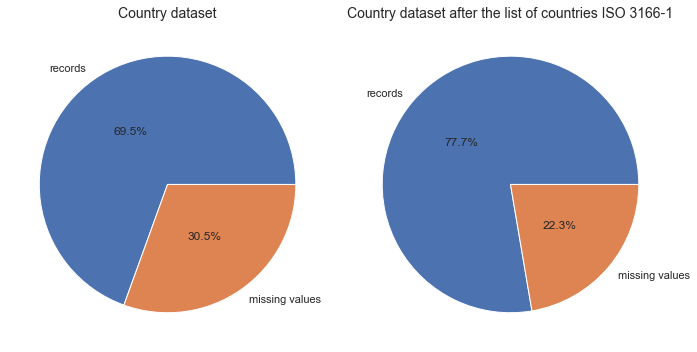

In [33]:
# Comparing missing values in Country dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country.shape)-country.isna().sum().sum(), country.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country dataset", fontsize=14)

vals_ax2 = [prod(country_copy.shape)-country_copy.isna().sum().sum(), country_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

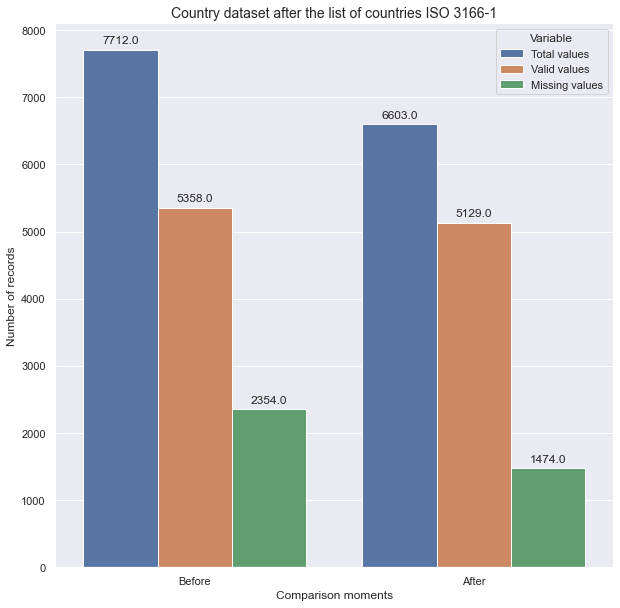

In [34]:
df_comparison = comparison_dfs(country, country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [35]:
df_initial_analysis(country_copy, "country copy")


Initial Analysis of country copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  213 rows and 31 columns
- Total of NaN values:            1474
- Percentage of NaN:              22.32 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      213
9                                           WB-2 code   object      213
2                                          Table Name   object      213
3                                           Long Name   object      213
4                                        2-alpha code   object      213
1                                          Short Name   object      213
15                        System of National Accounts  

In [36]:
country_copy.head(n=5)

Country Code   Short Name   Table Name                     Long Name  \
0          ABW        Aruba        Aruba                         Aruba   
1          AFG  Afghanistan  Afghanistan  Islamic State of Afghanistan   
2          AGO       Angola       Angola   People's Republic of Angola   
3          ALB      Albania      Albania           Republic of Albania   
4          AND      Andorra      Andorra       Principality of Andorra   

  2-alpha code   Currency Unit  \
0           AW   Aruban florin   
1           AF  Afghan afghani   
2           AO  Angolan kwanza   
3           AL    Albanian lek   
4           AD            Euro   

                                       Special Notes  \
0  SNA data for 2000-2011 are updated from offici...   
1  Fiscal year end: March 20; reporting period fo...   
2  April 2013 database update: Based on IMF data,...   
3                                                NaN   
4                                                NaN   

                      Region          Income Group WB-2 code  ...  \
0  Latin America & Caribbean  High income: nonOECD        AW  ...   
1                 South Asia            Low income        AF  ...   
2         Sub-Saharan Africa   Upper middle income        AO  ...   
3      Europe & Central Asia   Upper middle income        AL  ...   
4      Europe & Central Asia  High income: nonOECD        AD  ...   

     Government Accounting concept           IMF data dissemination standard  \
0                              NaN                                       NaN   
1  Consolidated central government  General Data Dissemination System (GDDS)   
2     Budgetary central government  General Data Dissemination System (GDDS)   
3     Budgetary central government  General Data Dissemination System (GDDS)   
4                              NaN                                       NaN   

                            Latest population census  \
0                                               2010   
1                                               1979   
2                                               1970   
3                                               2011   
4  2011. Population figures compiled from adminis...   

                             Latest household survey  \
0                                                NaN   
1  Multiple Indicator Cluster Survey (MICS), 2010/11   
2               Malaria Indicator Survey (MIS), 2011   
3       Demographic and Health Survey (DHS), 2008/09   
4                                                NaN   

   Source of most recent Income and expenditure data  \
0                                                NaN   
1            Integrated household survey (IHS), 2008   
2            Integrated household survey (IHS), 2008   
3  Living Standards Measurement Study Survey (LSM...   
4                                                NaN   

  Vital registration complete Latest agricultural census  \
0                         Yes                        NaN   
1                         NaN                    2013/14   
2                         NaN                       2015   
3                         Yes                       2012   
4                         Yes                        NaN   

  Latest industrial data Latest trade data Latest water withdrawal data  
0                    NaN            2012.0                          NaN  
1                    NaN            2012.0                         2000  
2                    NaN               NaN                         2005  
3                 2010.0            2012.0                         2006  
4                    NaN            2006.0                          NaN  

[5 rows x 31 columns]

### Cleaning **`"FootNote"`** dataset

In [37]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = foot_note_copy[~foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

CountryCode        SeriesCode    Year  \
7894           ARB  UIS.REPP.2.GPV.M  YR2006   
7895           ARB  UIS.REPP.2.GPV.M  YR2007   
7896           ARB  UIS.REPP.2.GPV.M  YR2008   
7897           ARB  UIS.REPP.2.GPV.M  YR2011   
7898           ARB  UIS.REPP.2.GPV.M  YR2014   
...            ...               ...     ...   
635823         XKX       SP.POP.GROW  YR2017   
635824         XKX       SP.POP.TOTL  YR2001   
635825         XKX       SP.POP.TOTL  YR2002   
635826         XKX       SP.POP.TOTL  YR2003   
635827         XKX       SP.POP.TOTL  YR2004   

                                              DESCRIPTION  
7894       UNESCO Institute for Statistics (UIS) estimate  
7895       UNESCO Institute for Statistics (UIS) estimate  
7896       UNESCO Institute for Statistics (UIS) estimate  
7897       UNESCO Institute for Statistics (UIS) estimate  
7898       UNESCO Institute for Statistics (UIS) estimate  
...                                                   ...  
635823             5-year average value between 0s and 5s  
635824  Interpolated between 2000 and 2005 assuming co...  
635825  Interpolated between 2000 and 2005 assuming co...  
635826  Interpolated between 2000 and 2005 assuming co...  
635827  Interpolated between 2000 and 2005 assuming co...  

[128636 rows x 4 columns]

In [38]:
# Filter "foot_note_copy" based on the list of "country_copy"
foot_note_copy = foot_note_copy[foot_note_copy["CountryCode"].isin(country_copy["Country Code"])]

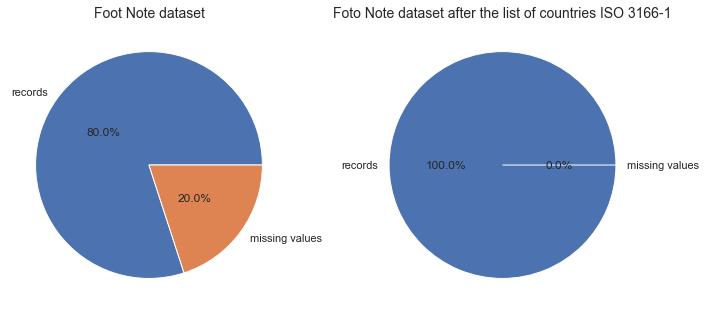

In [39]:
# Comparing missing values in Foot Note dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(foot_note.shape)-foot_note.isna().sum().sum(), foot_note.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Foot Note dataset", fontsize=14)

vals_ax2 = [prod(foot_note_copy.shape)-foot_note_copy.isna().sum().sum(), foot_note_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Foto Note dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

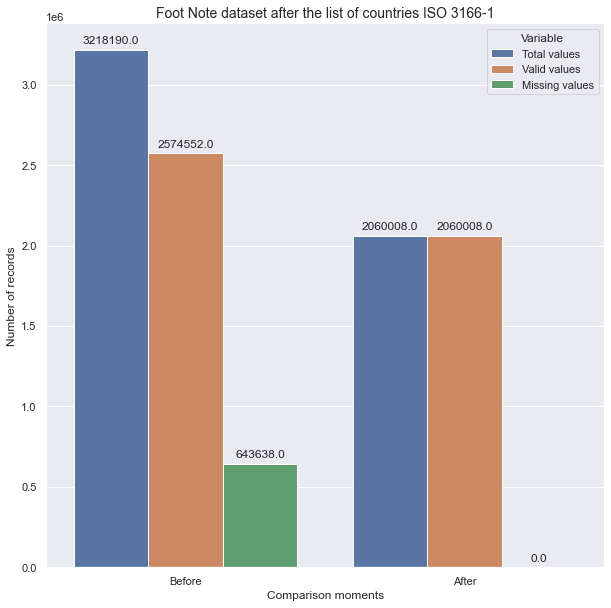

In [40]:
df_comparison = comparison_dfs(foot_note, foot_note_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Foot Note dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [41]:
df_initial_analysis(foot_note_copy, "foot note copy")


Initial Analysis of foot note copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  515002 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object   515002
1   SeriesCode  object   515002
2         Year  object   515002
3  DESCRIPTION  object   515002


### Cleaning **`"Country-Series"`** dataset

In [42]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = country_serie_copy[~country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]
df_print

CountryCode         SeriesCode  \
84          CHI        SP.POP.TOTL   
85          CHI  SP.POP.0014.TO.ZS   
86          CHI  SP.POP.1564.TO.ZS   
87          CHI        SP.POP.GROW   
88          CHI  SP.POP.TOTL.FE.ZS   
89          CHI  SP.POP.TOTL.MA.ZS   
392         NAM        SP.POP.GROW   
393         NAM        SP.POP.TOTL   
597         XKX        SP.POP.TOTL   
598         XKX  NY.GDP.MKTP.PP.KD   
599         XKX  NY.GNP.MKTP.PP.CD   
600         XKX        SP.POP.GROW   
601         XKX  NY.GDP.PCAP.PP.CD   
602         XKX  NY.GNP.PCAP.PP.CD   
603         XKX  NY.GDP.MKTP.PP.CD   
604         XKX  NY.GDP.PCAP.PP.KD   

                                           DESCRIPTION  
84   Data sources : United Nations World Population...  
85                     Refers to Guernsey, and Jersey.  
86                     Refers to Guernsey, and Jersey.  
87   Data sources: United Nations World Population ...  
88                     Refers to Guernsey, and Jersey.  
89                     Refers to Guernsey, and Jersey.  
392  Data sources: United Nations World Population ...  
393  Data sources : United Nations World Population...  
597  Data sources : World Bank's Kosovo coutnry off...  
598                 Estimates are based on regression.  
599                 Estimates are based on regression.  
600  Data sources: World Bank's Kosovo coutnry offi...  
601                 Estimates are based on regression.  
602                 Estimates are based on regression.  
603                 Estimates are based on regression.  
604                 Estimates are based on regression.

In [43]:
# Filter "country_serie_copy" based on the list of "country_copy"
country_serie_copy = country_serie_copy[country_serie_copy["CountryCode"].isin(country_copy["Country Code"])]

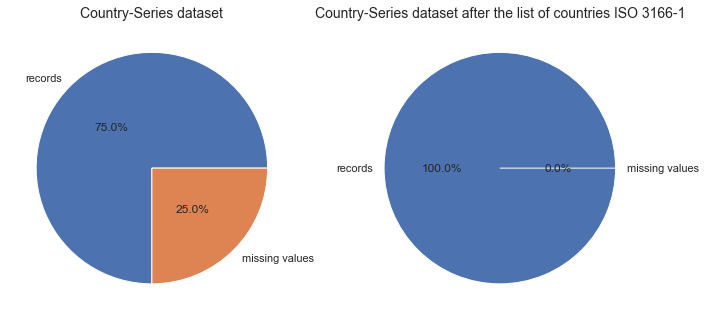

In [44]:
# Comparing missing values in Country-Series dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(country_serie.shape)-country_serie.isna().sum().sum(), country_serie.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(country_serie_copy.shape)-country_serie_copy.isna().sum().sum(), country_serie_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country-Series dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

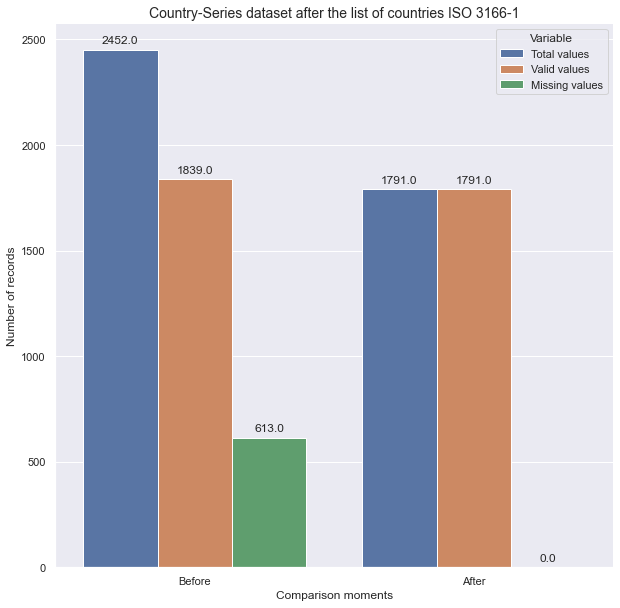

In [45]:
df_comparison = comparison_dfs(country_serie, country_serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country-Series dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [46]:
df_initial_analysis(country_serie_copy, "country-series copy")


Initial Analysis of country-series copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  597 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
          Name    Type  Records
0  CountryCode  object      597
1   SeriesCode  object      597
2  DESCRIPTION  object      597


### Cleaning **`"Data"`** dataset

In [47]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_print = data_copy[~data_copy["Country Code"].isin(country_copy["Country Code"])]
df_print

Country Name Country Code  \
0        Arab World          ARB   
1        Arab World          ARB   
2        Arab World          ARB   
3        Arab World          ARB   
4        Arab World          ARB   
...             ...          ...   
593725      Namibia          NAM   
593726      Namibia          NAM   
593727      Namibia          NAM   
593728      Namibia          NAM   
593729      Namibia          NAM   

                                           Indicator Name  \
0       Adjusted net enrolment rate, lower secondary, ...   
1       Adjusted net enrolment rate, lower secondary, ...   
2       Adjusted net enrolment rate, lower secondary, ...   
3       Adjusted net enrolment rate, lower secondary, ...   
4       Adjusted net enrolment rate, primary, both sex...   
...                                                   ...   
593725  Youth illiterate population, 15-24 years, male...   
593726  Youth literacy rate, population 15-24 years, b...   
593727  Youth literacy rate, population 15-24 years, f...   
593728  Youth literacy rate, population 15-24 years, g...   
593729  Youth literacy rate, population 15-24 years, m...   

              Indicator Code       1970       1971       1972       1973  \
0                 UIS.NERA.2        NaN        NaN        NaN        NaN   
1               UIS.NERA.2.F        NaN        NaN        NaN        NaN   
2             UIS.NERA.2.GPI        NaN        NaN        NaN        NaN   
3               UIS.NERA.2.M        NaN        NaN        NaN        NaN   
4                SE.PRM.TENR  54.822121  54.894138  56.209438  57.267109   
...                      ...        ...        ...        ...        ...   
593725      UIS.LP.AG15T24.M        NaN        NaN        NaN        NaN   
593726     SE.ADT.1524.LT.ZS        NaN        NaN        NaN        NaN   
593727  SE.ADT.1524.LT.FE.ZS        NaN        NaN        NaN        NaN   
593728  SE.ADT.1524.LT.FM.ZS        NaN        NaN        NaN        NaN   
593729  SE.ADT.1524.LT.MA.ZS        NaN        NaN        NaN        NaN   

             1974      1975  ...  2055  2060  2065  2070  2075  2080  2085  \
0             NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1             NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2             NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3             NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4       57.991138  59.36554  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...       ...  ...   ...   ...   ...   ...   ...   ...   ...   
593725        NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
593726        NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
593727        NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
593728        NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
593729        NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

        2090  2095  2100  
0        NaN   NaN   NaN  
1        NaN   NaN   NaN  
2        NaN   NaN   NaN  
3        NaN   NaN   NaN  
4        NaN   NaN   NaN  
...      ...   ...   ...  
593725   NaN   NaN   NaN  
593726   NaN   NaN   NaN  
593727   NaN   NaN   NaN  
593728   NaN   NaN   NaN  
593729   NaN   NaN   NaN  

[106285 rows x 69 columns]

In [48]:
# Filter "country_serie_copy" based on the list of "country_copy"
data_copy = data_copy[data_copy["Country Code"].isin(country_copy["Country Code"])]

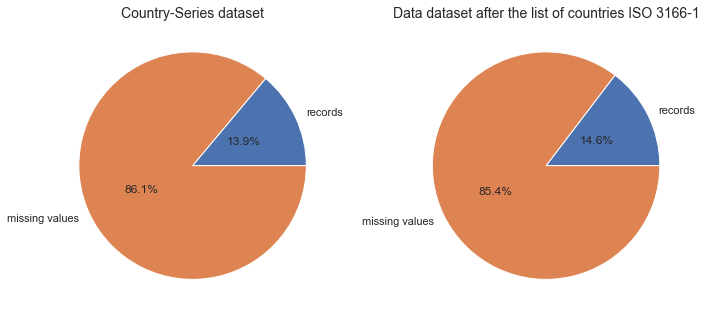

In [49]:
# Comparing missing values in Data dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(data.shape)-data.isna().sum().sum(), data.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(data_copy.shape)-data_copy.isna().sum().sum(), data_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Data dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()

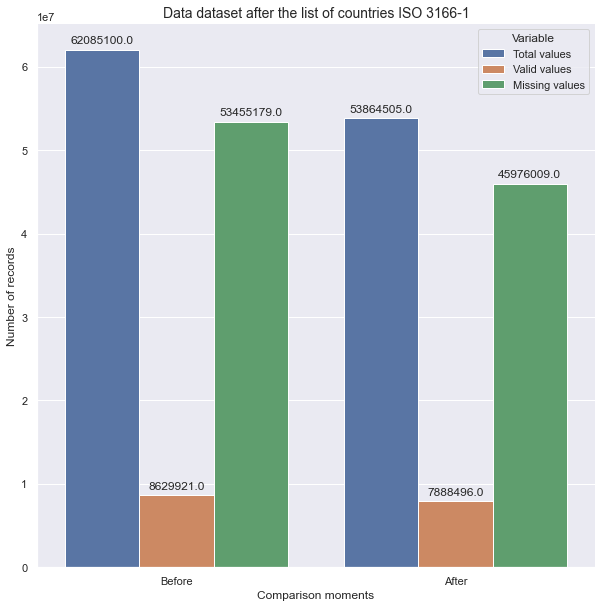

In [50]:
df_comparison = comparison_dfs(data, data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [51]:
df_initial_analysis(data_copy, "data copy")


Initial Analysis of data copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  780645 rows and 69 columns
- Total of NaN values:            45976009
- Percentage of NaN:              85.35 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   780645
1     Country Code   object   780645
2   Indicator Name   object   780645
3   Indicator Code   object   780645
44            2010  float64   232268
..             ...      ...      ...
6             1972  float64    31535
8             1974  float64    31495
7             1973  float64    31332
50            2016  float64    15600
51            2017  float64      143

[69 rows x 3 columns]


### Cleaning **`"Series"`** dataset

In [52]:
# Rows to remove based on list of countries as given in ISO 3166-1 and Data dataset as well. 
# In this case base on series filtered by list of countries
df_print = serie_copy[~serie_copy["Series Code"].isin(data_copy["Indicator Code"])]
df_print

Series Code                      Topic  \
2292                 SE.SEC.DURS.LO                   Secondary   
2314              SE.SEC.ENRR.UP.FE                   Secondary   
2717             UIS.AIR.1.Glast.GPI                    Primary   
2724                     UIS.CEAge.1                 Background   
2764                    UIS.E.0.Pu.F  Early Childhood Education   
2791                     UIS.E.1.Guk                    Primary   
2792                   UIS.E.1.Guk.F                    Primary   
2795                      UIS.E.1.Pu                    Primary   
2796                    UIS.E.1.Pu.F                    Primary   
2818                    UIS.E.2.Pu.F                  Secondary   
2823                     UIS.E.23.Pu                  Secondary   
2824                   UIS.E.23.Pu.F                  Secondary   
2832                    UIS.E.3.Pu.F                  Secondary   
2839                      UIS.E.4.Pu                   Tertiary   
2840                    UIS.E.4.Pu.F                   Tertiary   
2981              UIS.FOSEP.56.Fuk.F                   Tertiary   
3011                   UIS.GER.1t6.F                   Tertiary   
3012                 UIS.GER.1t6.GPI                   Tertiary   
3013                   UIS.GER.1t6.M                   Tertiary   
3052                  UIS.LP.Ag15t24                   Literacy   
3053                UIS.LP.Ag15t24.F                   Literacy   
3054                UIS.LP.Ag15t24.M                   Literacy   
3055                  UIS.LP.Ag15t99                   Literacy   
3056                UIS.LP.Ag15t99.F                   Literacy   
3058                     UIS.LP.Ag65                   Literacy   
3060                   UIS.LP.Ag65.M                   Literacy   
3062                 UIS.LPP.Ag15t99                   Literacy   
3063                    UIS.LPP.Ag65                   Literacy   
3064              UIS.LR.Ag15t99.GPI                   Literacy   
3070                   UIS.LR.Ag65.F                   Literacy   
3072                   UIS.LR.Ag65.M                   Literacy   
3238                  UIS.NIR.1.AgM1                    Primary   
3239                UIS.NIR.1.AgM1.F                    Primary   
3241                UIS.NIR.1.AgM1.M                    Primary   
3242                  UIS.NIR.1.AgP1                    Primary   
3243                UIS.NIR.1.AgP1.F                    Primary   
3245                UIS.NIR.1.AgP1.M                    Primary   
3257                UIS.OE.56.40510                    Tertiary   
3494                 UIS.SLE.1t6.GPI                   Tertiary   
3516              UIS.SR.1.Glast.GPI                    Primary   
3548                     UIS.thAge.0                Pre-Primary   
3549               UIS.thAge.3.A.GPV                  Secondary   
3550               UIS.thAge.4.A.GPV                   Tertiary   
3551                     UIS.thDur.0                Pre-Primary   
3552               UIS.thDur.4.A.GPV                   Tertiary   
3553           UIS.TranRA.23.GPV.GPI                  Secondary   
3582  UIS.XGDP.0.FSgov.FDinstadm.FFd               Expenditures   
3584  UIS.XGDP.1.FSgov.FDinstadm.FFd               Expenditures   
3590    UIS.XGDP.FSgov.FDinstadm.FFd               Expenditures   
3599                     UIS.XPubP.0               Expenditures   
3603                     UIS.XPubP.4               Expenditures   
3629      UIS.XSpendP.56.Fdpub.Fncap               Expenditures   
3631     UIS.XSpendP.56.Fdpub.Fnnons               Expenditures   

                                         Indicator Name  \
2292  Theoretical duration of lower secondary educat...   
2314  Gross enrolment ratio, upper secondary, female...   
2717  Primary completion rate, gender parity index (...   
2724  Official entrance age to compulsory education ...   
2764  Enrolment in early childhood education, public...   
2791  Enrolment in primary education, Grade unspecif

In [53]:
# Filter "serie_copy" based on the list of "country_copy"
# In this case base on series filtered by list of countries
serie_copy = serie_copy[serie_copy["Series Code"].isin(data_copy["Indicator Code"])]

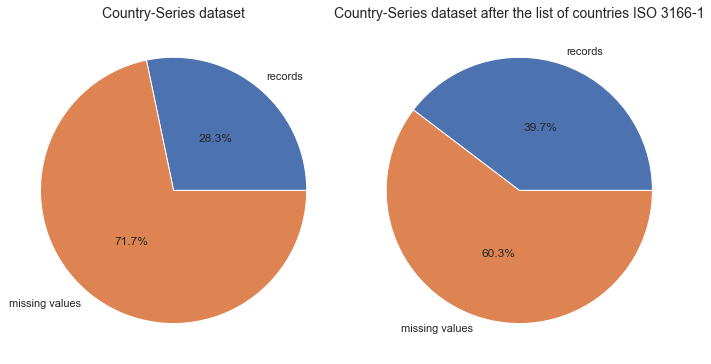

In [54]:
# Comparing missing values in Series dataset before and after removing empty columns/rows
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,20])
labels = ["records", "missing values"]
explode = (0, 0.01)

vals_ax1 = [prod(serie.shape)-serie.isna().sum().sum(), serie.isna().sum().sum()]
ax1.pie(x=vals_ax1, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax1.set_title("Country-Series dataset", fontsize=14)

vals_ax2 = [prod(serie_copy.shape)-serie_copy.isna().sum().sum(), serie_copy.isna().sum().sum()]
ax2.pie(x=vals_ax2, labels=labels, autopct="%.1f%%", pctdistance=0.5)
ax2.set_title("Country-Series dataset after the list of countries ISO 3166-1", fontsize=14)

plt.tight_layout()
plt.show()


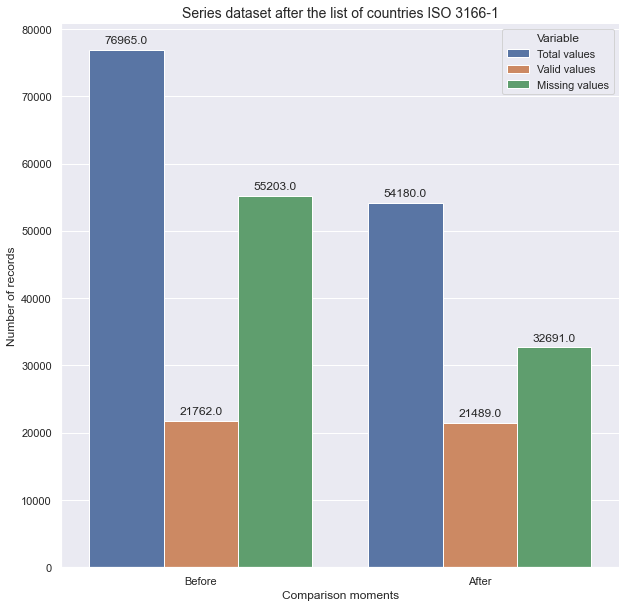

In [55]:
df_comparison = comparison_dfs(serie, serie_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Series dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

In [56]:
df_initial_analysis(serie_copy, "series copy")


Initial Analysis of series copy dataset
--------------------------------------------------------------------------
- Dataset shape:                  3612 rows and 15 columns
- Total of NaN values:            32691
- Percentage of NaN:              60.34 %
- Total of full duplicates rows:  0
- Total of empty columns:         0

- Type object and records by columns
--------------------------------------------------------------------------
                                   Name    Type  Records
0                           Series Code  object     3612
1                                 Topic  object     3612
2                        Indicator Name  object     3612
4                       Long definition  object     3612
11                               Source  object     3612
3                      Short definition  object     2152
7                           Other notes  object      548
6                           Base Period  object      314
14                 Related source links  obje

## Analysis of data
- Data number by **`"Year"`**.
- Series number by **`"Year"`**.
    - **`"Foot Note"`** dataset **`"EdStatsFootNote.csv"`**.<br>
    L’année d’origine des données et aussi une description sur les indicateurs.
- Amount of countries by **`"Year"`**.
- Amount of data by **`"Country"`**.
- Amount of data by **`"Region"`**.
- Incomes types by **`"Region"`**.
- Amount of indicator by **`"Region"`**.
- Amount of indicator by **`"Country"`**.
- Most commons words within I**`"ndicators"`**.
- Amount of data by **`"indicators"`**.
- Amount of data by **`"Topic"`**.

### Analyse Data with **`"sample"`** based on the years from **`2005`** to **`2015`**
- Heatmap by **`"Country"`**.
- Amount of data by **`"Topic"`**.


### Analysis of data

In [57]:
data_copy.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100'],
      dtype='object')

In [58]:
# Years present within Data dataset
YEARS = [
    "1970", "1971", "1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979", 
    "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", 
    "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", 
    "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", 
    "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", 
    "2020", "2025", "2030", "2035", "2040", "2045", "2050"
]

In [59]:
df_number_data_by_year = pd.DataFrame(data_copy[YEARS].replace("", np.nan).count())
df_number_data_by_year.tail(10)

0
2015  128382
2016   15600
2017     143
2020   50820
2025   50820
2030   50820
2035   50820
2040   50820
2045   50820
2050   50820

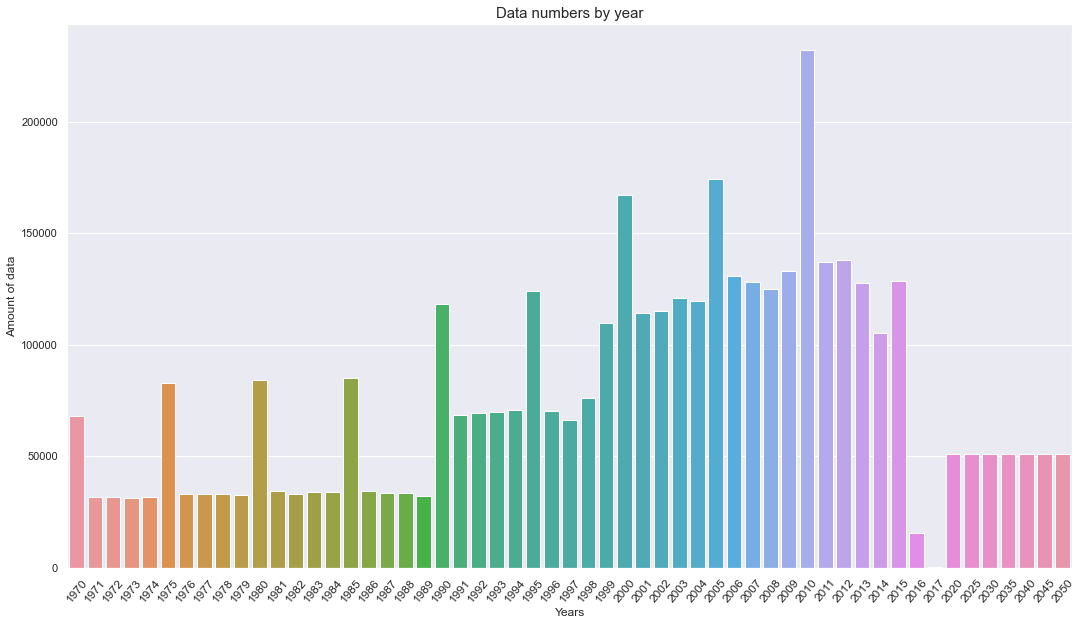

In [60]:
# Graph amount of data by year
plt.figure(figsize=(18, 10))
plt.title("Data numbers by year", size=15)
plot = sns.barplot(y=df_number_data_by_year.iloc[:,0], x=df_number_data_by_year.index, data=df_number_data_by_year)
plot.set_xticklabels(labels=df_number_data_by_year.index, rotation=50, size=12)
plot.set(xlabel="Years", ylabel="Amount of data")
plt.show()

In [61]:
foot_note_copy.head(n=5)

CountryCode      SeriesCode    Year          DESCRIPTION
0         ABW  SE.PRE.ENRL.FE  YR2001  Country estimation.
1         ABW  SE.TER.TCHR.FE  YR2005  Country estimation.
2         ABW  SE.PRE.TCHR.FE  YR2000  Country estimation.
3         ABW  SE.SEC.ENRL.GC  YR2004  Country estimation.
4         ABW     SE.PRE.TCHR  YR2006  Country estimation.

In [62]:
# Formatting columns year to work with it
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("YR", "")
foot_note_copy["Year"] = foot_note_copy["Year"].str.replace("yr", "")
foot_note_copy.head(n=5)

CountryCode      SeriesCode  Year          DESCRIPTION
0         ABW  SE.PRE.ENRL.FE  2001  Country estimation.
1         ABW  SE.TER.TCHR.FE  2005  Country estimation.
2         ABW  SE.PRE.TCHR.FE  2000  Country estimation.
3         ABW  SE.SEC.ENRL.GC  2004  Country estimation.
4         ABW     SE.PRE.TCHR  2006  Country estimation.

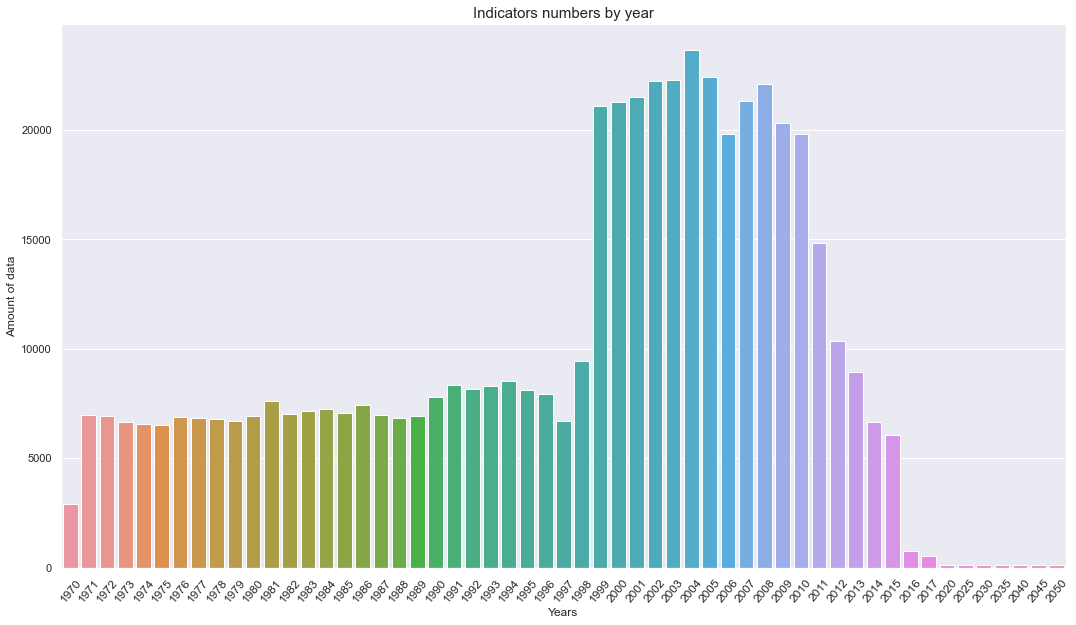

In [63]:
# Graph amount of Series by year
plt.figure(figsize=(18, 10))
plt.title("Indicators numbers by year", size=15)
plot = sns.barplot(y="SeriesCode", x="Year", data=foot_note_copy.groupby("Year").count().reset_index())
plot.set_xticklabels(labels=foot_note_copy.groupby("Year").count().reset_index()["Year"], rotation=50, size=12)
plot.set(xlabel="Years", ylabel="Amount of data")
plt.show()

In [64]:
# Analyzing amount of countries by year
list_countries_by_year = list(YEARS)
list_countries_by_year.append("Country Code")

In [65]:
print(", ".join(map(repr, list_countries_by_year)))

'1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', 'Country Code'


In [66]:

df_countries_by_year = pd.DataFrame(data_copy[list_countries_by_year]).dropna(axis="rows", how="all").dropna(axis="columns", how="all")
df_countries_by_year

1970  1971  1972  1973      1974  1975  1976  1977  1978  1979  ...  \
91625    NaN   NaN   NaN   NaN   7.05911   NaN   NaN   NaN   NaN   NaN  ...   
91626    NaN   NaN   NaN   NaN   2.53138   NaN   NaN   NaN   NaN   NaN  ...   
91627    NaN   NaN   NaN   NaN   0.22154   NaN   NaN   NaN   NaN   NaN  ...   
91628    NaN   NaN   NaN   NaN  11.42652   NaN   NaN   NaN   NaN   NaN  ...   
91629    NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
...      ...   ...   ...   ...       ...   ...   ...   ...   ...   ...  ...   
886925   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
886926   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
886927   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
886928   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
886929   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   

        2016  2017  2020  2025  2030  2035  2040  2045  2050  Country Code  
91625    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           AFG  
91626    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           AFG  
91627    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           AFG  
91628    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           AFG  
91629    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           AFG  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...           ...  
886925   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           ZWE  
886926   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           ZWE  
886927   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           ZWE  
886928   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           ZWE  
886929   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN           ZWE  

[780645 rows x 56 columns]

In [67]:
# Calculating the amount of countries by year. 
df_countries_by_year = countries_by_year(df_countries_by_year)
df_countries_by_year.head(10)

Year  Countries
0  1970        212
1  1971        212
2  1972        212
3  1973        212
4  1974        212
5  1975        212
6  1976        212
7  1977        212
8  1978        212
9  1979        212

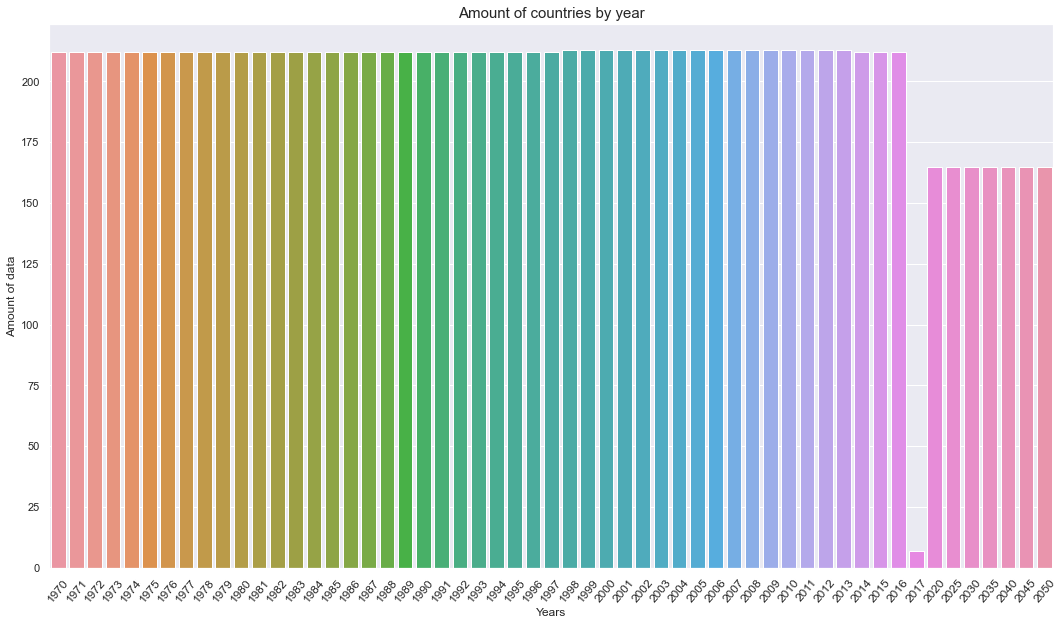

In [68]:
# Graph amount of countries by year
plt.figure(figsize=(18, 10))
plt.title("Amount of countries by year", size=15)
plot = sns.barplot(y="Countries", x="Year", data=df_countries_by_year)
plot.set_xticklabels(labels=df_countries_by_year["Year"], rotation=50, size=12)
plot.set(xlabel="Years", ylabel="Amount of data")
plt.show()

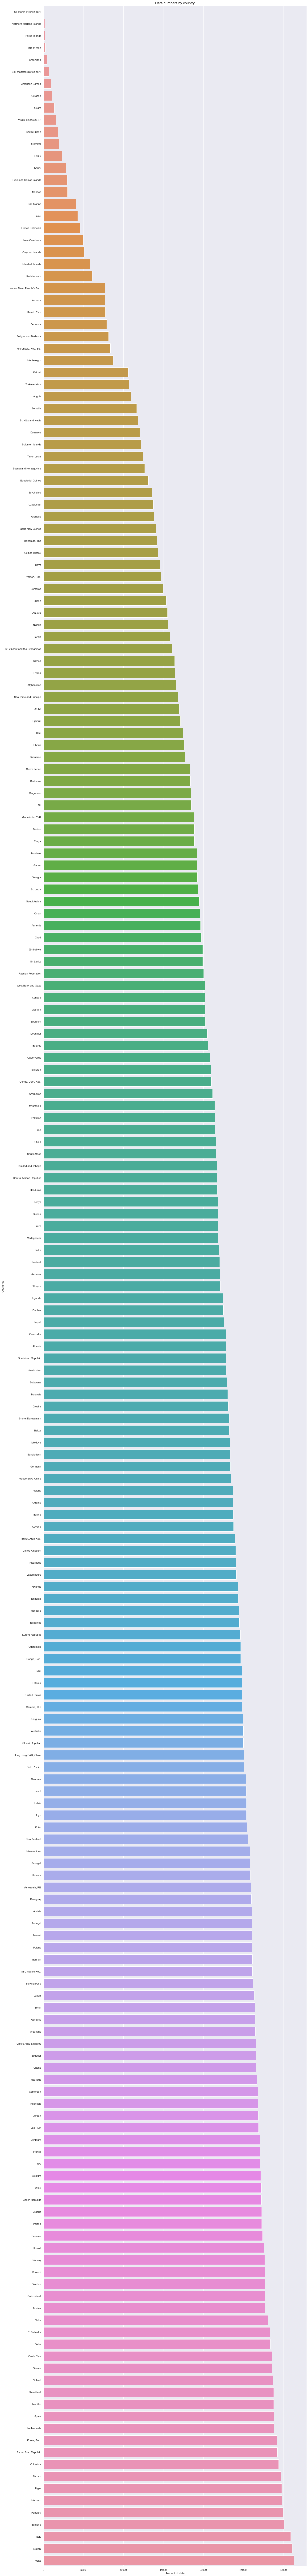

In [69]:
# Graph amount of data by country
plt.figure(figsize=(20, 200))
plt.title("Data numbers by country", size=15)
plot = sns.barplot(x=data_copy.groupby("Country Name")[YEARS].count().sum(axis=1).sort_values().values,
                   y=data_copy.groupby("Country Name")[YEARS].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Countries")
plt.show()

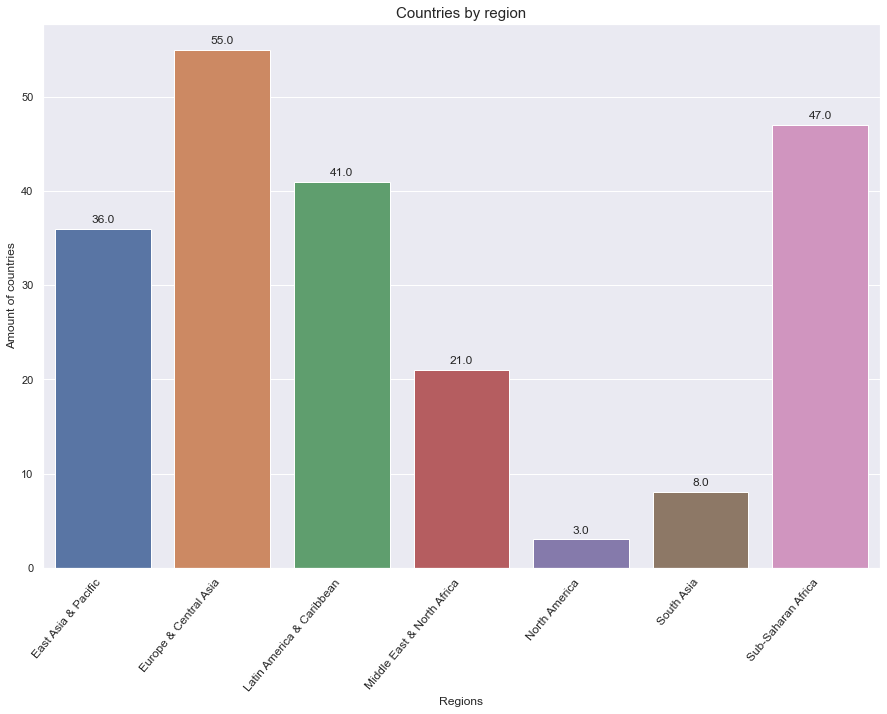

In [70]:
# Graph countries by region
df_countries_by_region = country_copy[["Short Name", "Region"]].groupby("Region").count()

plt.figure(figsize=(15, 10))
plt.title("Countries by region", size=15)
plot = sns.barplot(x="Region", y="Short Name", data=df_countries_by_region.reset_index())
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Regions", size=12)
plt.ylabel("Amount of countries", size=12)
plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=50, size=12, horizontalalignment="right")
plt.show()

In [71]:
# Adding column region within Data dataset
data_copy = data_copy.merge(right=country_copy[["Country Code", "Region"]], 
                  on="Country Code", how="left")

In [72]:
data_copy.head(5)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                      Indicator Name  Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   NaN   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   NaN   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   NaN   
4  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   NaN   

   1971  1972  1973      1974  1975  ...  2060  2065  2070  2075  2080  2085  \
0   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2090  2095  2100      Region  
0   NaN   NaN   NaN  South Asia  
1   NaN   NaN   NaN  South Asia  
2   NaN   NaN   NaN  South Asia  
3   NaN   NaN   NaN  South Asia  
4   NaN   NaN   NaN  South Asia  

[5 rows x 70 columns]

In [73]:
# Graph amount of data by region
plt.figure(figsize=(15, 10))
plt.title("Data numbers by region", size=15)
plot = sns.barplot(x=data_copy.groupby("Region")[YEARS].count().sum(axis=1).sort_values().values,
                   y=data_copy.groupby("Region")[YEARS].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Regions")
plt.show()

In [74]:
# Filtering and grouping by Income Group and Region
df_types_incomes_by_region = pd.DataFrame(country_copy[["Income Group", "Short Name", "Region"]]
                                            .groupby(["Income Group", "Region"])["Short Name"].count()).reset_index()

In [75]:
df_types_incomes_by_region.head(8)

Income Group                      Region  Short Name
0     High income: OECD         East Asia & Pacific           4
1     High income: OECD       Europe & Central Asia          23
2     High income: OECD   Latin America & Caribbean           1
3     High income: OECD  Middle East & North Africa           1
4     High income: OECD               North America           2
5  High income: nonOECD         East Asia & Pacific           8
6  High income: nonOECD       Europe & Central Asia          12
7  High income: nonOECD   Latin America & Caribbean          14

In [76]:
# Knowing the Incomes types
list(df_types_incomes_by_region["Income Group"].unique())

['High income: OECD',
 'High income: nonOECD',
 'Low income',
 'Lower middle income',
 'Upper middle income']

In [77]:
# Creating DataFrame order to add it within df_types_incomes_by_region
df_incomes_order = pd.DataFrame({
    "Income Group" : ["High income: OECD", "High income: nonOECD", "Upper middle income", "Lower middle income", "Low income"], 
    "Order" : [0, 1, 2, 3, 4]
})
df_incomes_order

Income Group  Order
0     High income: OECD      0
1  High income: nonOECD      1
2   Upper middle income      2
3   Lower middle income      3
4            Low income      4

In [78]:
# Adding order column to improve the graph
df_types_incomes_by_region = pd.merge(df_types_incomes_by_region, df_incomes_order).sort_values("Order")
df_types_incomes_by_region.head(12)

Income Group                      Region  Short Name  Order
0      High income: OECD         East Asia & Pacific           4      0
1      High income: OECD       Europe & Central Asia          23      0
2      High income: OECD   Latin America & Caribbean           1      0
3      High income: OECD  Middle East & North Africa           1      0
4      High income: OECD               North America           2      0
5   High income: nonOECD         East Asia & Pacific           8      1
6   High income: nonOECD       Europe & Central Asia          12      1
7   High income: nonOECD   Latin America & Caribbean          14      1
8   High income: nonOECD  Middle East & North Africa           7      1
9   High income: nonOECD               North America           1      1
10  High income: nonOECD          Sub-Saharan Africa           1      1
25   Upper middle income  Middle East & North Africa           7      2

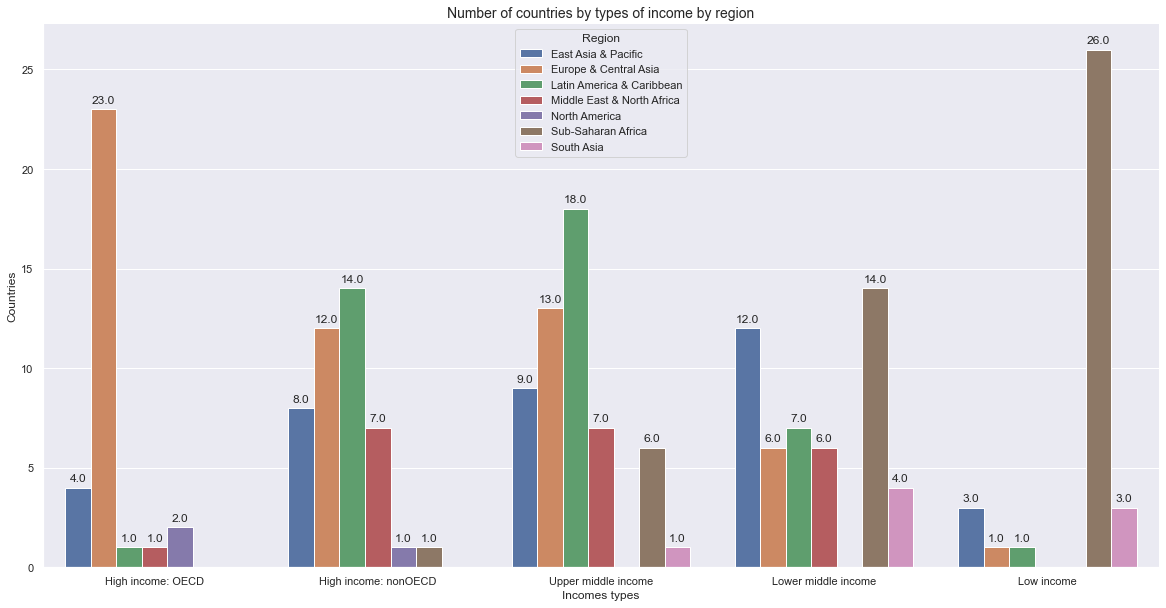

In [79]:
fig, ax1 = plt.subplots(figsize=(20, 10))
plot = sns.barplot(x="Income Group", y="Short Name", hue="Region", data=df_types_incomes_by_region, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Incomes types", size=12)
plt.ylabel("Countries", size=12)
plt.title("Number of countries by types of income by region", size=14)
sns.despine(fig)

In [80]:
# Amount of Indicators in Data dataset
data_copy['Indicator Code'].nunique()

3665

In [81]:
data.head(4)

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   

                                      Indicator Name  Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   NaN   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   NaN   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   NaN   

   1971  1972  1973  1974  1975  ...  2060  2065  2070  2075  2080  2085  \
0   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2090  2095  2100  Unnamed: 69  
0   NaN   NaN   NaN          NaN  
1   NaN   NaN   NaN          NaN  
2   NaN   NaN   NaN          NaN  
3   NaN   NaN   NaN          NaN  

[4 rows x 70 columns]

In [82]:
# Amount of Indicators by country
df_indicators_by_country = pd.DataFrame(data_copy[["Country Name", "Indicator Code"]]\
                                        .groupby("Country Name")["Indicator Code"].count()).reset_index()

In [83]:
df_indicators_by_country

Country Name  Indicator Code
0              Afghanistan            3665
1                  Albania            3665
2                  Algeria            3665
3           American Samoa            3665
4                  Andorra            3665
..                     ...             ...
208  Virgin Islands (U.S.)            3665
209     West Bank and Gaza            3665
210            Yemen, Rep.            3665
211                 Zambia            3665
212               Zimbabwe            3665

[213 rows x 2 columns]

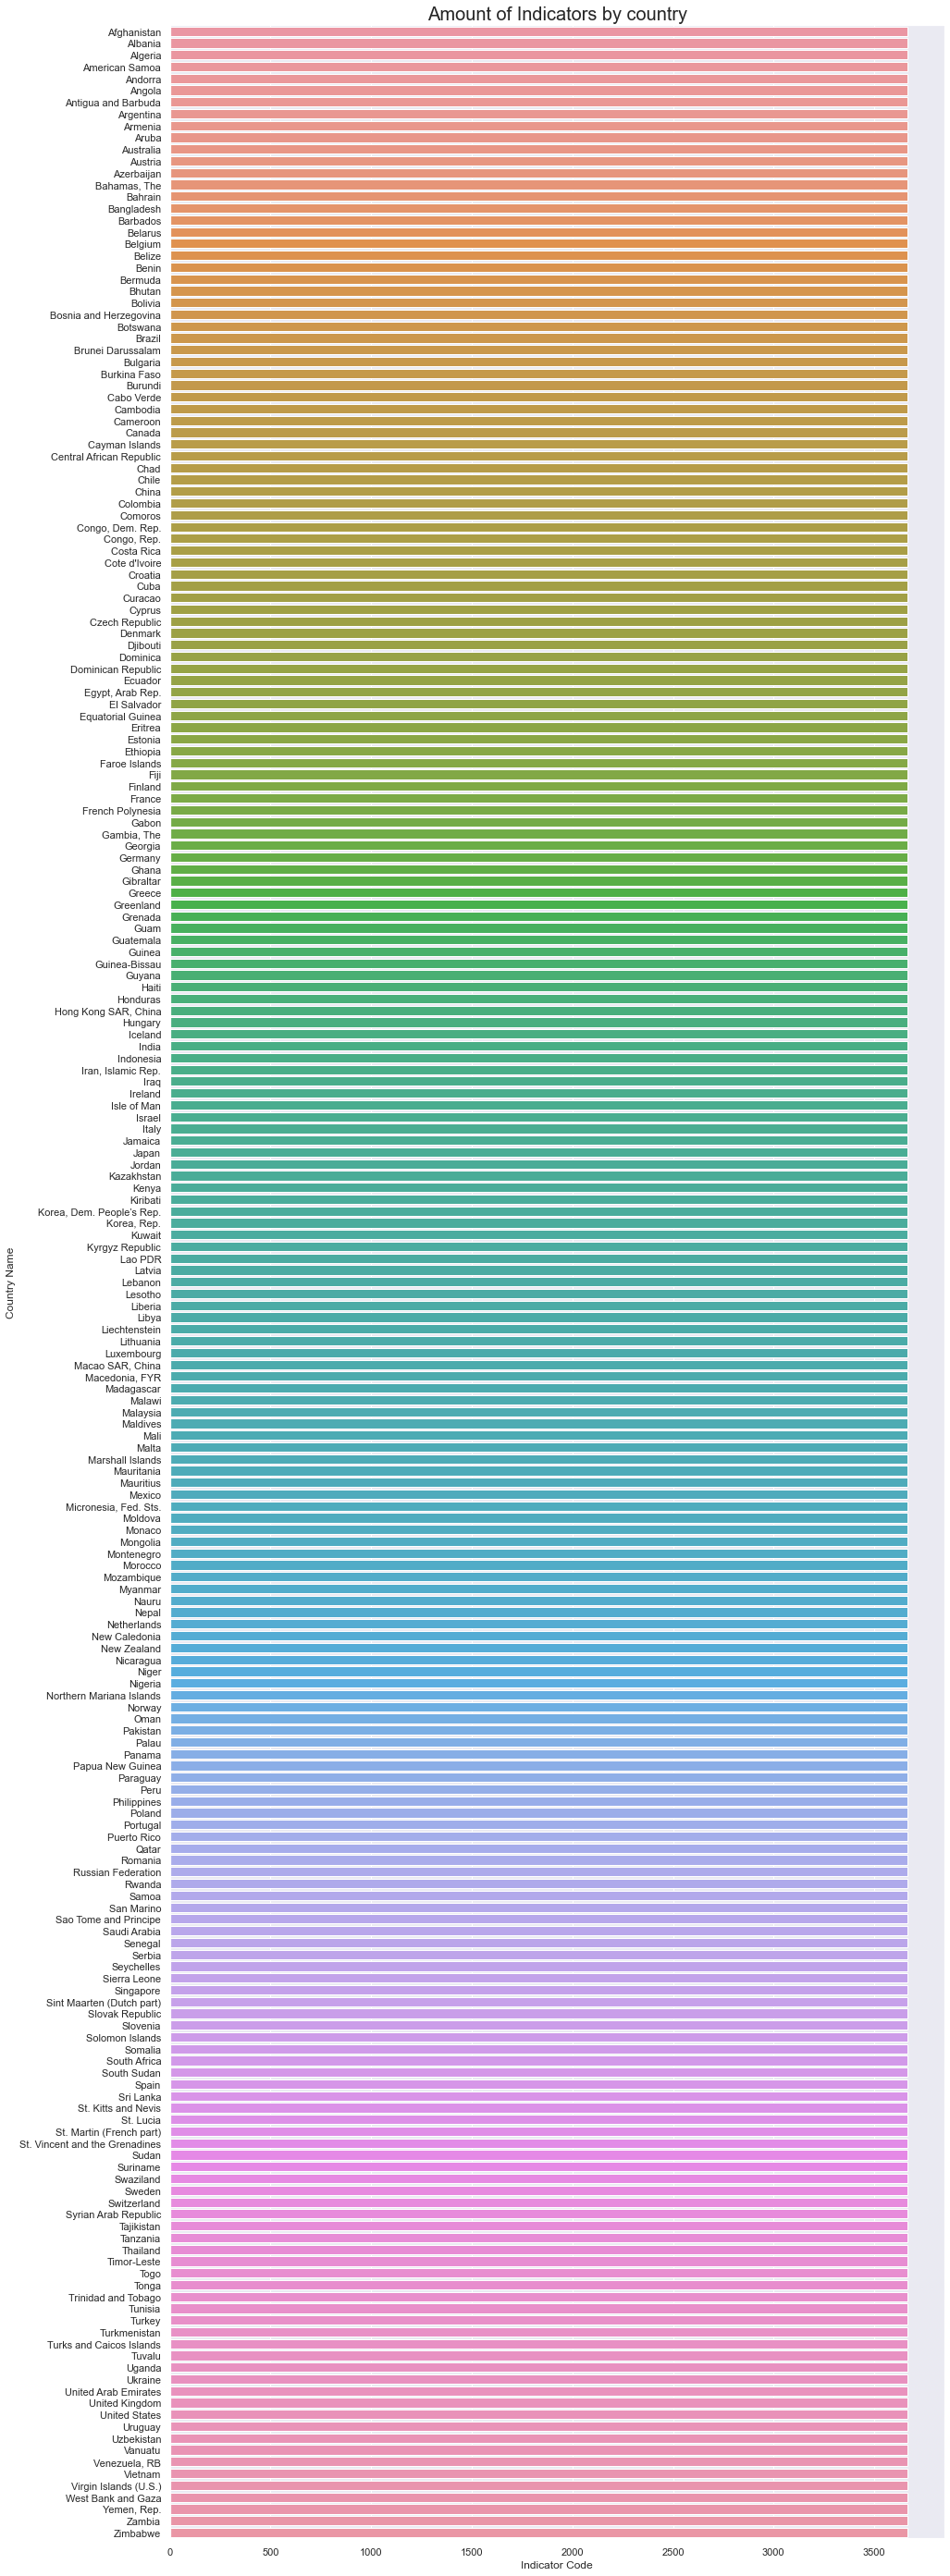

In [84]:
# Amount of Indicators by country
plt.figure(figsize=(15, 50))
sns.barplot(y="Country Name", x="Indicator Code", data=df_indicators_by_country)
plt.title("Amount of Indicators by country", size=20)
plot.set(xlabel="Amount", ylabel="Countries")
plt.show()

In [85]:
# Identify the most common words
df_most_common_words = most_common_words(data_copy["Indicator Name"].tolist(), 20)
print(df_most_common_words)

            Word  Occurence number
19    Repetition              8946
18    Government              9159
17       SACMEQ:             11502
16         Gross             12993
15        PIAAC:             20874
14         PISA:             21087
13        TIMSS:             21300
12        Africa             21513
11     Enrolment             21939
10         MICS:             25560
9         LLECE:             27051
8           DHS:             27690
7         PASEC:             29820
6    Population,             41109
5         SABER:             45795
4     Percentage             50907
3           UIS:             51333
2   Wittgenstein             65604
1     Barro-Lee:             76680
0          EGRA:             85839


In [86]:
# The most common words within indicator
plt.figure(figsize=(20, 10))
sns.barplot(y="Word", x="Occurence number", data=df_most_common_words)
plt.title("The 20 most common words within the indicators", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.show()

In [87]:
data_copy.head(10)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   
5  Afghanistan          AFG   
6  Afghanistan          AFG   
7  Afghanistan          AFG   
8  Afghanistan          AFG   
9  Afghanistan          AFG   

                                      Indicator Name  Indicator Code  1970  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   NaN   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   NaN   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   NaN   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   NaN   
4  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   NaN   
5   Adjusted net enrolment rate, primary, female (%)  SE.PRM.TENR.FE   NaN   
6  Adjusted net enrolment rate, primary, gender p...  UIS.NERA.1.GPI   NaN   
7     Adjusted net enrolment rate, primary, male (%)  SE.PRM.TENR.MA   NaN   
8  Adjusted net enrolment rate, upper secondary, ...      UIS.NERA.3   NaN   
9  Adjusted net enrolment rate, upper secondary, ...    UIS.NERA.3.F   NaN   

   1971  1972  1973      1974  1975  ...  2060  2065  2070  2075  2080  2085  \
0   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
5   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
6   NaN   NaN   NaN   0.19066   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
7   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
8   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   
9   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2090  2095  2100      Region  
0   NaN   NaN   NaN  South Asia  
1   NaN   NaN   NaN  South Asia  
2   NaN   NaN   NaN  South Asia  
3   NaN   NaN   NaN  South Asia  
4   NaN   NaN   NaN  South Asia  
5   NaN   NaN   NaN  South Asia  
6   NaN   NaN   NaN  South Asia  
7   NaN   NaN   NaN  South Asia  
8   NaN   NaN   NaN  South Asia  
9   NaN   NaN   NaN  South Asia  

[10 rows x 70 columns]

In [88]:
# Calculating among of indicator by years
list_amount_of_indicators = list(YEARS)
list_amount_of_indicators.insert(0, "Indicator Name")
print(", ".join(map(repr, list_amount_of_indicators)))

'Indicator Name', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050'


In [89]:
# Extracting the indicators and its years. 
df_indicators = pd.DataFrame(data_copy[list_amount_of_indicators].groupby("Indicator Name").count()\
                                .sort_values(by="Indicator Name", ascending=True)).reset_index()
df_indicators

Indicator Name  1970  1971  1972  \
0     Adjusted net enrolment rate, lower secondary, ...     4    29    29   
1     Adjusted net enrolment rate, lower secondary, ...     2    24    25   
2     Adjusted net enrolment rate, lower secondary, ...     2    24    24   
3     Adjusted net enrolment rate, lower secondary, ...     2    24    24   
4     Adjusted net enrolment rate, primary, both sex...     0     0     0   
...                                                 ...   ...   ...   ...   
3660  Youth illiterate population, 15-24 years, male...     3     0     0   
3661  Youth literacy rate, population 15-24 years, b...     3     0     0   
3662  Youth literacy rate, population 15-24 years, f...     3     0     0   
3663  Youth literacy rate, population 15-24 years, g...     3     0     0   
3664  Youth literacy rate, population 15-24 years, m...     3     0     0   

      1973  1974  1975  1976  1977  1978  ...  2015  2016  2017  2020  2025  \
0       25    29    22    27    31    31  ...     3     0     0     0     0   
1       22    24    20    22    27    26  ...     3     0     0     0     0   
2       22    24    20    22    27    26  ...     3     0     0     0     0   
3       22    24    20    22    27    26  ...     3     0     0     0     0   
4        0     0     0     0     0     0  ...   113     9     0     0     0   
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   
3660     0     0     5     8     1     2  ...    31    17     0     0     0   
3661     0     0     5     8     1     2  ...    32    17     0     0     0   
3662     0     0     5     8     1     2  ...    32    17     0     0     0   
3663     0     0     5     8     1     2  ...    32    17     0     0     0   
3664     0     0     5     8     1     2  ...    32    17     0     0     0   

      2030  2035  2040  2045  2050  
0        0     0     0     0     0  
1        0     0     0     0     0  
2        0     0     0     0     0  
3        0     0     0     0     0  
4        0     0     0     0     0  
...    ...   ...   ...   ...   ...  
3660     0     0     0     0     0  
3661     0     0     0     0     0  
3662     0     0     0     0     0  
3663     0     0     0     0     0  
3664     0     0     0     0     0  

[3665 rows x 56 columns]

In [90]:
# Calculating the sum of each indicators by all years
df_indicators["Total"] = df_indicators.sum(axis=1)
df_indicators

Indicator Name  1970  1971  1972  \
0     Adjusted net enrolment rate, lower secondary, ...     4    29    29   
1     Adjusted net enrolment rate, lower secondary, ...     2    24    25   
2     Adjusted net enrolment rate, lower secondary, ...     2    24    24   
3     Adjusted net enrolment rate, lower secondary, ...     2    24    24   
4     Adjusted net enrolment rate, primary, both sex...     0     0     0   
...                                                 ...   ...   ...   ...   
3660  Youth illiterate population, 15-24 years, male...     3     0     0   
3661  Youth literacy rate, population 15-24 years, b...     3     0     0   
3662  Youth literacy rate, population 15-24 years, f...     3     0     0   
3663  Youth literacy rate, population 15-24 years, g...     3     0     0   
3664  Youth literacy rate, population 15-24 years, m...     3     0     0   

      1973  1974  1975  1976  1977  1978  ...  2016  2017  2020  2025  2030  \
0       25    29    22    27    31    31  ...     0     0     0     0     0   
1       22    24    20    22    27    26  ...     0     0     0     0     0   
2       22    24    20    22    27    26  ...     0     0     0     0     0   
3       22    24    20    22    27    26  ...     0     0     0     0     0   
4        0     0     0     0     0     0  ...     9     0     0     0     0   
...    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   
3660     0     0     5     8     1     2  ...    17     0     0     0     0   
3661     0     0     5     8     1     2  ...    17     0     0     0     0   
3662     0     0     5     8     1     2  ...    17     0     0     0     0   
3663     0     0     5     8     1     2  ...    17     0     0     0     0   
3664     0     0     5     8     1     2  ...    17     0     0     0     0   

      2035  2040  2045  2050  Total  
0        0     0     0     0   2394  
1        0     0     0     0   2250  
2        0     0     0     0   2238  
3        0     0     0     0   2238  
4        0     0     0     0   2151  
...    ...   ...   ...   ...    ...  
3660     0     0     0     0    710  
3661     0     0     0     0    714  
3662     0     0     0     0    713  
3663     0     0     0     0    713  
3664     0     0     0     0    713  

[3665 rows x 57 columns]

### Amount of data by **`"Indicators"`**

In [91]:
# Default value is 10 rows to print. Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
df_indicators[["Indicator Name", "Total"]].sort_values("Total", ascending=False)\
                                            .style.set_table_styles(
                                                [
                                                    {
                                                        "selector" : "th",
                                                        "props" : [
                                                            ("text-align", "left")
                                                        ]
                                                    },                                                     
                                                    {
                                                        "selector" : "td",
                                                        "props" : [
                                                            ("text-align", "left")
                                                        ]
                                                    }
                                            ])

### Indicators **`"Topic"`**

In [92]:
# Default value is 10 rows to print. Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 10)

In [93]:
data_copy.head(5)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                                            Indicator Name  \
0             Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                 Adjusted net enrolment rate, lower secondary, female (%)   
2  Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                   Adjusted net enrolment rate, lower secondary, male (%)   
4                     Adjusted net enrolment rate, primary, both sexes (%)   

   Indicator Code  1970  1971  1972  1973      1974  1975  ...  2060  2065  \
0      UIS.NERA.2   NaN   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   
1    UIS.NERA.2.F   NaN   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   
2  UIS.NERA.2.GPI   NaN   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   
3    UIS.NERA.2.M   NaN   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   
4     SE.PRM.TENR   NaN   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   

   2070  2075  2080  2085  2090  2095  2100      Region  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  

[5 rows x 70 columns]

In [94]:
# Adding column Topic within Data dataset
data_copy = data_copy.merge(right=serie_copy[["Indicator Name", "Topic"]], 
                  on="Indicator Name", how="left")

In [95]:
data_copy.head(5)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                                            Indicator Name  \
0             Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                 Adjusted net enrolment rate, lower secondary, female (%)   
2  Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                   Adjusted net enrolment rate, lower secondary, male (%)   
4                     Adjusted net enrolment rate, primary, both sexes (%)   

   Indicator Code  1970  1971  1972  1973      1974  1975  ...  2065  2070  \
0      UIS.NERA.2   NaN   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   
1    UIS.NERA.2.F   NaN   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   
2  UIS.NERA.2.GPI   NaN   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   
3    UIS.NERA.2.M   NaN   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   
4     SE.PRM.TENR   NaN   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   

   2075  2080  2085  2090  2095  2100      Region      Topic  
0   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
1   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
2   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
3   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
4   NaN   NaN   NaN   NaN   NaN   NaN  South Asia    Primary  

[5 rows x 71 columns]

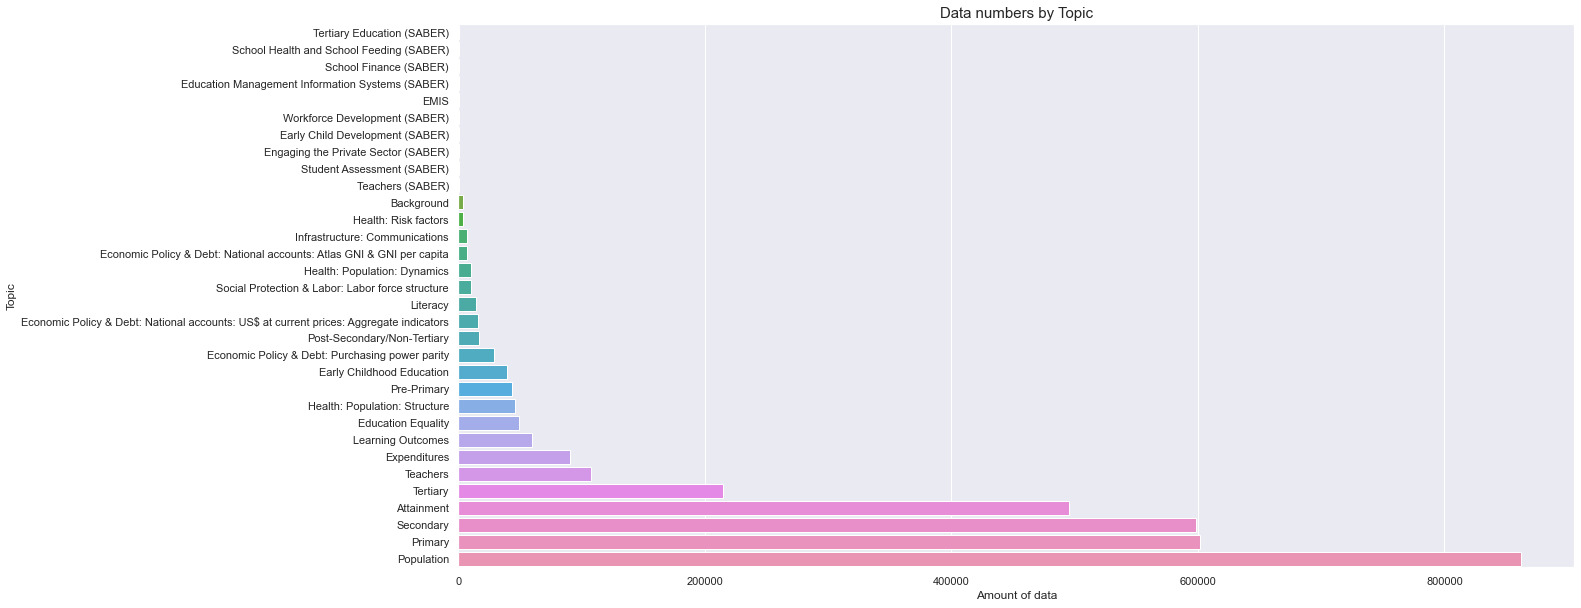

In [96]:
# Graph amount of data by topic
plt.figure(figsize=(20, 10))
plt.title("Data numbers by Topic", size=15)
plot = sns.barplot(x=data_copy.groupby("Topic")[YEARS].count().sum(axis=1).sort_values().values,
                   y=data_copy.groupby("Topic")[YEARS].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Topic")
plt.show()

In [97]:
data_copy.head(5)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                                            Indicator Name  \
0             Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                 Adjusted net enrolment rate, lower secondary, female (%)   
2  Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                   Adjusted net enrolment rate, lower secondary, male (%)   
4                     Adjusted net enrolment rate, primary, both sexes (%)   

   Indicator Code  1970  1971  1972  1973      1974  1975  ...  2065  2070  \
0      UIS.NERA.2   NaN   NaN   NaN   NaN   7.05911   NaN  ...   NaN   NaN   
1    UIS.NERA.2.F   NaN   NaN   NaN   NaN   2.53138   NaN  ...   NaN   NaN   
2  UIS.NERA.2.GPI   NaN   NaN   NaN   NaN   0.22154   NaN  ...   NaN   NaN   
3    UIS.NERA.2.M   NaN   NaN   NaN   NaN  11.42652   NaN  ...   NaN   NaN   
4     SE.PRM.TENR   NaN   NaN   NaN   NaN       NaN   NaN  ...   NaN   NaN   

   2075  2080  2085  2090  2095  2100      Region      Topic  
0   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
1   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
2   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
3   NaN   NaN   NaN   NaN   NaN   NaN  South Asia  Secondary  
4   NaN   NaN   NaN   NaN   NaN   NaN  South Asia    Primary  

[5 rows x 71 columns]

In [98]:
# Amount of Indicator by Topic
plt.figure(figsize=(20, 10))
plt.title("Numbers of Indicators by Topic", size=15)
plot = sns.barplot(x=serie_copy[["Topic", "Series Code"]].groupby("Topic")["Series Code"].count().index,
                   y=serie_copy[["Topic", "Series Code"]].groupby("Topic")["Series Code"].count())
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=50, size=12, horizontalalignment="right")
plot.set(xlabel="Topic", ylabel="Amount of Indicators")
plt.show()

## Analyse Data with sample based on the years from 2005 to 2015
Selecting the mos recent years based on the amount of data.<br>
To more details, see graphics **`"Data numbers by Years"`** and **`"Series numbers by Years"`**

In [99]:
# Years to work since they have more data and are the most recent
YEARS_TO_WORK = [
    "2005", "2006", "2007", "2008", "2009", 
    "2010", "2011", "2012", "2013", "2014", "2015"
]

In [100]:
data_sample_years_to_work = data_copy.groupby(['Country Name']).count()[YEARS_TO_WORK]
data_sample_years_to_work.head()

2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
Country Name                                                                 
Afghanistan      741   321   411   375   429   761   682   434   446   543   
Albania          864   518   574   849   937  1347   872   926   890   693   
Algeria         1051   764   809   691   682  1366   689   541   538   492   
American Samoa     8    10    16     8     8     8     8     8     8     8   
Andorra          449   571   349   373   346   349   326   373   454   430   

                2015  
Country Name          
Afghanistan      352  
Albania          797  
Algeria          730  
American Samoa     8  
Andorra          156

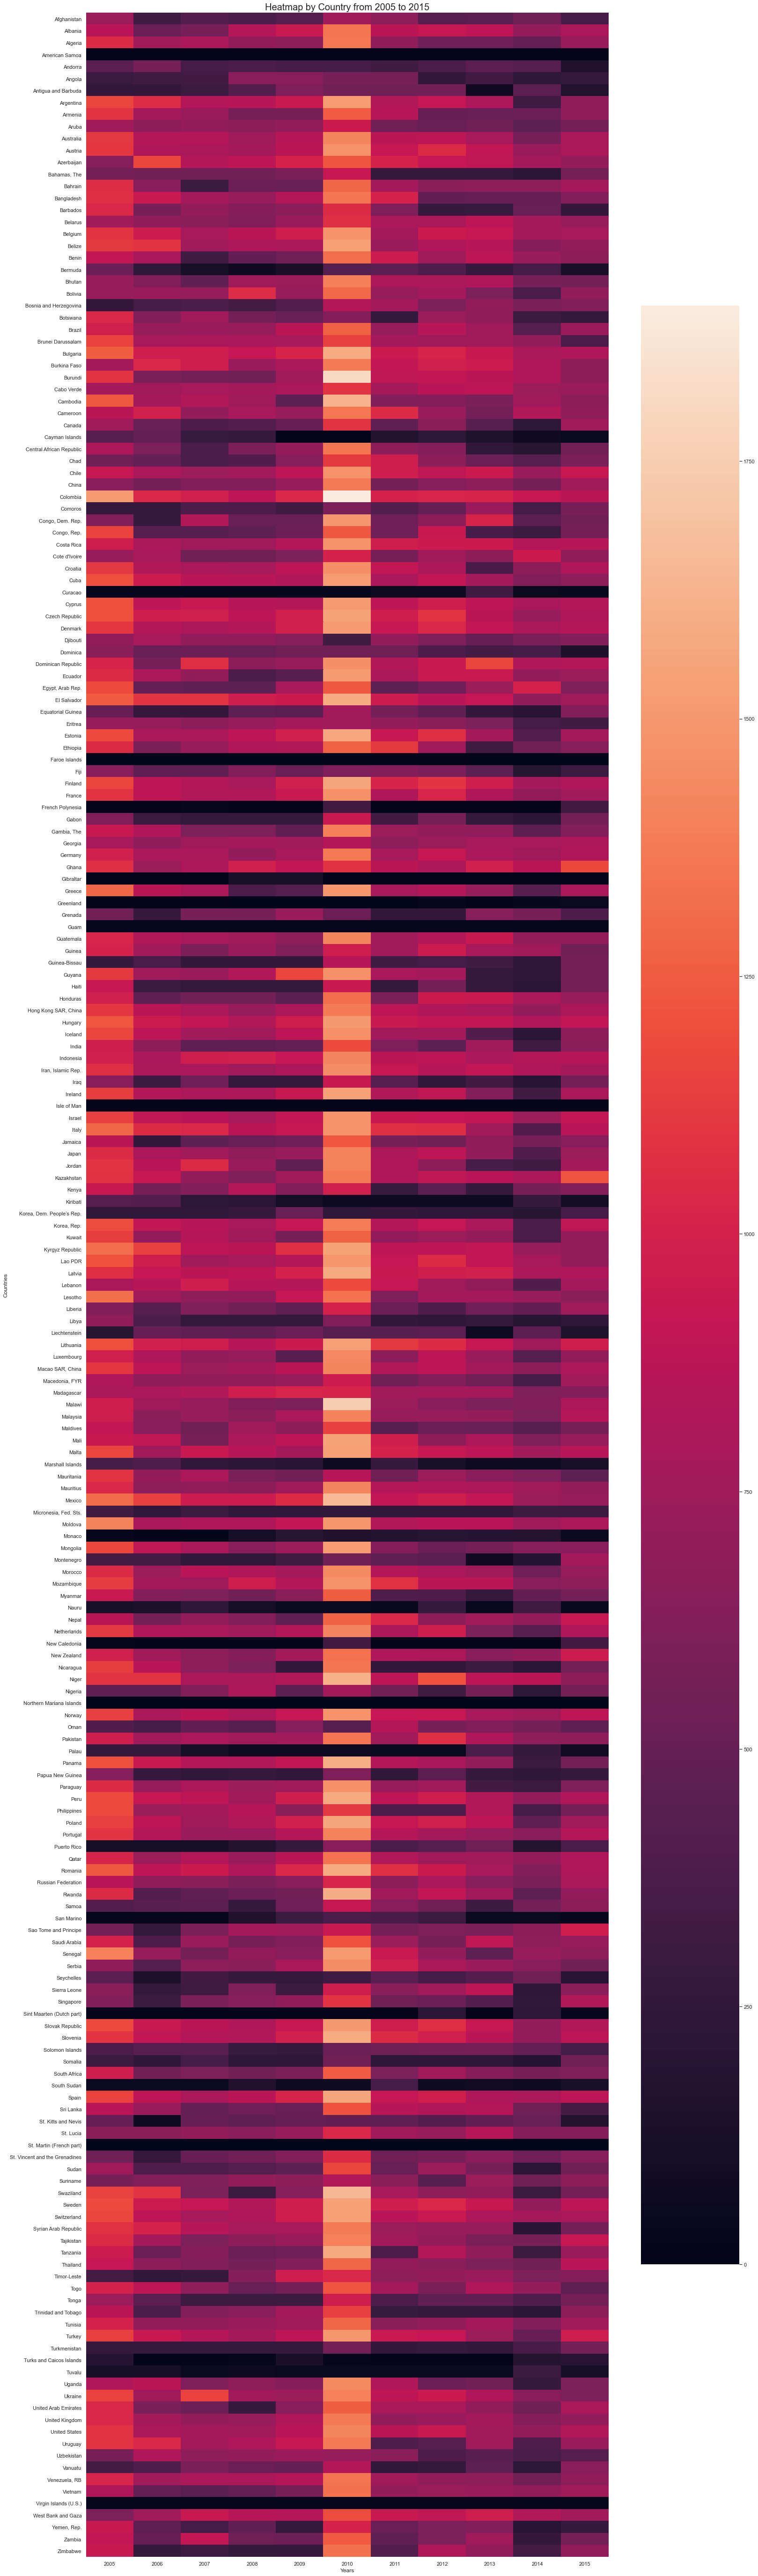

In [101]:
# Heatmap by Country from 2005 to 2015
plt.figure(figsize = (25,100))
plt.title("Heatmap by Country from 2005 to 2015", size=20)
plot = sns.heatmap(data_sample_years_to_work)
plot.set(xlabel="Years", ylabel="Countries")
plt.show()

In [102]:
list_data_sample = ["Country Name", "Country Code", "Indicator Name", "Indicator Code", "Region", "Topic"]
list_data_sample = list_data_sample + YEARS_TO_WORK
print(", ".join(map(repr, list_data_sample)))


'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Region', 'Topic', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'


In [103]:
data_sample = pd.DataFrame(data_copy[list_data_sample])
data_sample

Country Name Country Code  \
0       Afghanistan          AFG   
1       Afghanistan          AFG   
2       Afghanistan          AFG   
3       Afghanistan          AFG   
4       Afghanistan          AFG   
...             ...          ...   
780640     Zimbabwe          ZWE   
780641     Zimbabwe          ZWE   
780642     Zimbabwe          ZWE   
780643     Zimbabwe          ZWE   
780644     Zimbabwe          ZWE   

                                                                 Indicator Name  \
0                  Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                      Adjusted net enrolment rate, lower secondary, female (%)   
2       Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                        Adjusted net enrolment rate, lower secondary, male (%)   
4                          Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                         ...   
780640                  Youth illiterate population, 15-24 years, male (number)   
780641              Youth literacy rate, population 15-24 years, both sexes (%)   
780642                  Youth literacy rate, population 15-24 years, female (%)   
780643   Youth literacy rate, population 15-24 years, gender parity index (GPI)   
780644                    Youth literacy rate, population 15-24 years, male (%)   

              Indicator Code              Region      Topic  2005  2006  \
0                 UIS.NERA.2          South Asia  Secondary   NaN   NaN   
1               UIS.NERA.2.F          South Asia  Secondary   NaN   NaN   
2             UIS.NERA.2.GPI          South Asia  Secondary   NaN   NaN   
3               UIS.NERA.2.M          South Asia  Secondary   NaN   NaN   
4                SE.PRM.TENR          South Asia    Primary   NaN   NaN   
...                      ...                 ...        ...   ...   ...   
780640      UIS.LP.AG15T24.M  Sub-Saharan Africa        NaN   NaN   NaN   
780641     SE.ADT.1524.LT.ZS  Sub-Saharan Africa   Literacy   NaN   NaN   
780642  SE.ADT.1524.LT.FE.ZS  Sub-Saharan Africa   Literacy   NaN   NaN   
780643  SE.ADT.1524.LT.FM.ZS  Sub-Saharan Africa   Literacy   NaN   NaN   
780644  SE.ADT.1524.LT.MA.ZS  Sub-Saharan Africa   Literacy   NaN   NaN   

             2007  2008  2009  2010          2011  2012       2013  \
0       28.059870   NaN   NaN   NaN           NaN   NaN  47.436790   
1       15.223100   NaN   NaN   NaN           NaN   NaN  34.073261   
2        0.379130   NaN   NaN   NaN           NaN   NaN   0.567060   
3       40.152851   NaN   NaN   NaN           NaN   NaN  60.087059   
4             NaN   NaN   NaN   NaN           NaN   NaN        NaN   
...           ...   ...   ...   ...           ...   ...        ...   
780640        NaN   NaN   NaN   NaN  166679.00000   NaN        NaN   
780641        NaN   NaN   NaN   NaN      90.93070   NaN        NaN   
780642        NaN   NaN   NaN   NaN      92.12456   NaN        NaN   
780643        NaN   NaN   NaN   NaN       1.02828   NaN        NaN   
780644        NaN   NaN   NaN   NaN      89.59058   NaN        NaN   

                 2014  2015  
0           50.627232   NaN  
1           37.641541   NaN  
2            0.598370   NaN  
3           62.906952   NaN  
4                 NaN   NaN  
...               ...   ...  
780640  199464.000000   NaN  
780641      90.428120   NaN  
780642      93.188350   NaN  
780643       1.063890   NaN  
780644      87.591860   NaN  

[780645 rows x 17 columns]

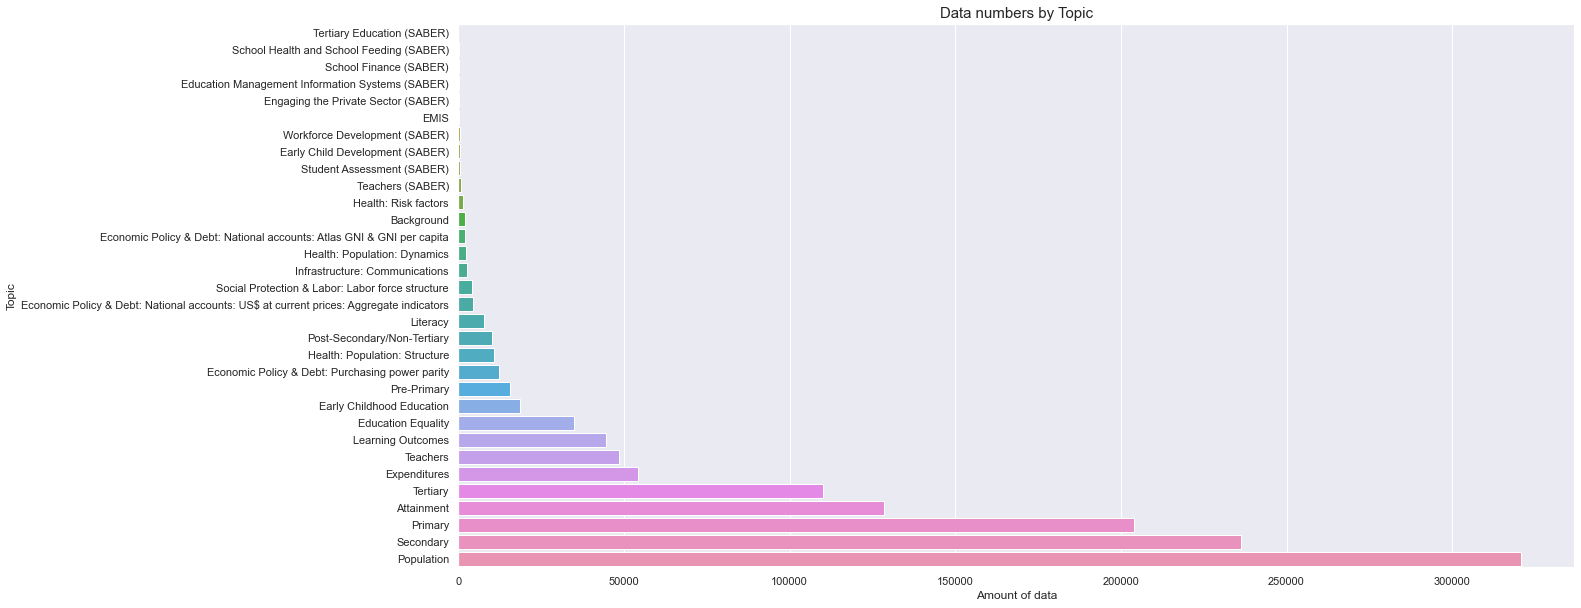

In [104]:
# Graph amount of data by topic from 2005 to 2015
plt.figure(figsize=(20, 10))
plt.title("Data numbers by Topic", size=15)
plot = sns.barplot(x=data_sample.groupby("Topic")[YEARS_TO_WORK].count().sum(axis=1).sort_values().values,
                   y=data_sample.groupby("Topic")[YEARS_TO_WORK].count().sum(axis=1).sort_values().index
)
plot.set(xlabel="Amount of data", ylabel="Topic")
plt.show()

In [105]:
# Calculating among of indicator by years 
list_amount_of_indicators = ["Indicator Name", "Indicator Code"] + list(YEARS_TO_WORK)
print(", ".join(map(repr, list_amount_of_indicators)))

'Indicator Name', 'Indicator Code', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'


In [106]:
# Extracting the indicators and its years from 2005 to 2015
df_indicators = pd.DataFrame(data_sample[list_amount_of_indicators].groupby(["Indicator Name", "Indicator Code"]).count()\
                                .sort_values(by="Indicator Name", ascending=True)).reset_index()
df_indicators

Indicator Name  \
0                Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                    Adjusted net enrolment rate, lower secondary, female (%)   
2     Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                      Adjusted net enrolment rate, lower secondary, male (%)   
4                        Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                       ...   
3660                  Youth illiterate population, 15-24 years, male (number)   
3661              Youth literacy rate, population 15-24 years, both sexes (%)   
3662                  Youth literacy rate, population 15-24 years, female (%)   
3663   Youth literacy rate, population 15-24 years, gender parity index (GPI)   
3664                    Youth literacy rate, population 15-24 years, male (%)   

            Indicator Code  2005  2006  2007  2008  2009  2010  2011  2012  \
0               UIS.NERA.2   104    97   103   102   112   106   107   102   
1             UIS.NERA.2.F   100    94   100   100   110   103   106   101   
2           UIS.NERA.2.GPI   100    94   100   100   110   103   106   101   
3             UIS.NERA.2.M   100    94   100   100   110   103   106   101   
4              SE.PRM.TENR   131   124   131   131   137   130   132   135   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
3660      UIS.LP.AG15T24.M    20    26    33    31    32    47    56    41   
3661     SE.ADT.1524.LT.ZS    20    26    33    31    32    47    56    41   
3662  SE.ADT.1524.LT.FE.ZS    20    26    33    31    32    47    56    41   
3663  SE.ADT.1524.LT.FM.ZS    20    26    33    31    32    47    56    41   
3664  SE.ADT.1524.LT.MA.ZS    20    26    33    31    32    47    56    41   

      2013  2014  2015  
0       99    85     3  
1       98    84     3  
2       98    84     3  
3       98    84     3  
4      126   130   113  
...    ...   ...   ...  
3660    29    36    31  
3661    29    36    32  
3662    29    36    32  
3663    29    36    32  
3664    29    36    32  

[3665 rows x 13 columns]

In [107]:
# Calculating the sum of each indicators by all years
df_indicators["Total"] = df_indicators.sum(axis=1)
df_indicators

Indicator Name  \
0                Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                    Adjusted net enrolment rate, lower secondary, female (%)   
2     Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                      Adjusted net enrolment rate, lower secondary, male (%)   
4                        Adjusted net enrolment rate, primary, both sexes (%)   
...                                                                       ...   
3660                  Youth illiterate population, 15-24 years, male (number)   
3661              Youth literacy rate, population 15-24 years, both sexes (%)   
3662                  Youth literacy rate, population 15-24 years, female (%)   
3663   Youth literacy rate, population 15-24 years, gender parity index (GPI)   
3664                    Youth literacy rate, population 15-24 years, male (%)   

            Indicator Code  2005  2006  2007  2008  2009  2010  2011  2012  \
0               UIS.NERA.2   104    97   103   102   112   106   107   102   
1             UIS.NERA.2.F   100    94   100   100   110   103   106   101   
2           UIS.NERA.2.GPI   100    94   100   100   110   103   106   101   
3             UIS.NERA.2.M   100    94   100   100   110   103   106   101   
4              SE.PRM.TENR   131   124   131   131   137   130   132   135   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
3660      UIS.LP.AG15T24.M    20    26    33    31    32    47    56    41   
3661     SE.ADT.1524.LT.ZS    20    26    33    31    32    47    56    41   
3662  SE.ADT.1524.LT.FE.ZS    20    26    33    31    32    47    56    41   
3663  SE.ADT.1524.LT.FM.ZS    20    26    33    31    32    47    56    41   
3664  SE.ADT.1524.LT.MA.ZS    20    26    33    31    32    47    56    41   

      2013  2014  2015  Total  
0       99    85     3   1020  
1       98    84     3    999  
2       98    84     3    999  
3       98    84     3    999  
4      126   130   113   1420  
...    ...   ...   ...    ...  
3660    29    36    31    382  
3661    29    36    32    383  
3662    29    36    32    383  
3663    29    36    32    383  
3664    29    36    32    383  

[3665 rows x 14 columns]

In [108]:
# Default value is 10 rows to print. Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
df_indicators[["Indicator Code", "Indicator Name", "Total"]].sort_values("Total", ascending=False)\
                                                                .style.set_table_styles(
                                                                    [
                                                                        {
                                                                            "selector" : "th",
                                                                            "props" : [
                                                                                ("text-align", "left")
                                                                            ]
                                                                        },                                                     
                                                                        {
                                                                            "selector" : "td",
                                                                            "props" : [
                                                                                ("text-align", "left")
                                                                            ]
                                                                        }
                                                                ])

In [109]:
pd.set_option('display.max_rows', 10)

## Selecting the **`"Indicators"`**
Considering the following **`"Academy"`** premises to define the expansion plan.<br>
- **`"Academy"`** is a EdTech start-up
- The **`"Academy"`** market is online training content for high school and university level audiences.
- Countries which have a strong potential of customers for **`"Academy"`** services.
    - Potential customer development for each of these countries

We can consider some **`"key words"`** or **`"topics"`** to select the **`"Indicators"`**
- Internet access / Internet use
- Access to a computer / Access to a personal computer
- Purchasing power
- Population in secondary, college, graduate courses, university
- Financing for education / Funding for education

In [110]:
data_sample.head(5)

Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                                            Indicator Name  \
0             Adjusted net enrolment rate, lower secondary, both sexes (%)   
1                 Adjusted net enrolment rate, lower secondary, female (%)   
2  Adjusted net enrolment rate, lower secondary, gender parity index (GPI)   
3                   Adjusted net enrolment rate, lower secondary, male (%)   
4                     Adjusted net enrolment rate, primary, both sexes (%)   

   Indicator Code      Region      Topic  2005  2006       2007  2008  2009  \
0      UIS.NERA.2  South Asia  Secondary   NaN   NaN  28.059870   NaN   NaN   
1    UIS.NERA.2.F  South Asia  Secondary   NaN   NaN  15.223100   NaN   NaN   
2  UIS.NERA.2.GPI  South Asia  Secondary   NaN   NaN   0.379130   NaN   NaN   
3    UIS.NERA.2.M  South Asia  Secondary   NaN   NaN  40.152851   NaN   NaN   
4     SE.PRM.TENR  South Asia    Primary   NaN   NaN        NaN   NaN   NaN   

   2010  2011  2012       2013       2014  2015  
0   NaN   NaN   NaN  47.436790  50.627232   NaN  
1   NaN   NaN   NaN  34.073261  37.641541   NaN  
2   NaN   NaN   NaN   0.567060   0.598370   NaN  
3   NaN   NaN   NaN  60.087059  62.906952   NaN  
4   NaN   NaN   NaN        NaN        NaN   NaN

In [111]:
INDICATORS = (
    "internet", "computer", "capita", "GDP", "population", "education", 
    "secondary", "university", "college", "school", "bachelor", "financing", 
    "funding"
)

In [112]:
data_sample = pd.DataFrame(data_sample[data_sample["Indicator Name"].reset_index().stack().str.contains("|".join(INDICATORS), case=False, na=False)                             .any(level=0)])

In [113]:
data_sample.shape

(495651, 17)

In [114]:
data_sample["Indicator Name"].nunique() 

2327

Indicator
- Internet users (per 100 people) / IT.NET.USER.P2
- Population, ages 15-24, total / SP.POP.1524.TO.UN


In [115]:
data_sample.describe()

2005          2006          2007          2008          2009  \
count  1.642520e+05  1.123580e+05  1.132110e+05  1.152190e+05  1.157020e+05   
mean   1.489709e+09  2.325681e+09  2.478230e+09  2.554211e+09  2.509728e+09   
std    8.460377e+10  1.077320e+11  1.131225e+11  1.156175e+11  1.150803e+11   
min   -2.966054e+00 -3.278564e+00 -3.589465e+00 -3.561055e+00 -3.332301e+00   
25%    5.480000e+00  1.371141e+01  1.303795e+01  1.254109e+01  1.275860e+01   
50%    4.785188e+01  1.214500e+03  1.141000e+03  7.190000e+02  7.165000e+02   
75%    3.325675e+04  1.702642e+05  1.715145e+05  1.628840e+05  1.617592e+05   
max    1.470557e+13  1.509771e+13  1.536623e+13  1.532142e+13  1.489617e+13   

               2010          2011          2012          2013          2014  \
count  2.210770e+05  1.205070e+05  1.187340e+05  1.167080e+05  9.582600e+04   
mean   1.396584e+09  2.719615e+09  2.852122e+09  3.009820e+09  3.793603e+09   
std    8.800422e+10  1.258212e+11  1.325155e+11  1.394247e+11  1.612056e+11   
min   -3.333512e+00 -2.628656e+00 -2.147571e+00 -3.040564e+00 -7.400000e+00   
25%    1.102530e+00  1.209387e+01  1.199890e+01  1.367448e+01  1.623750e+01   
50%    1.676000e+01  1.480000e+02  2.320000e+02  7.831085e+02  3.960000e+02   
75%    3.245000e+03  1.420555e+05  1.482272e+05  1.643095e+05  1.819580e+05   
max    1.527333e+13  1.551793e+13  1.615526e+13  1.678803e+13  1.833566e+13   

               2015  
count  1.134470e+05  
mean   3.240439e+09  
std    1.543907e+11  
min   -2.467847e+00  
25%    2.800000e-01  
50%    5.297488e+01  
75%    1.026395e+05  
max    1.985273e+13

In [116]:
data_sample_by_indicator = pd.DataFrame(data_sample[data_sample["Indicator Name"] == "Internet users (per 100 people)"]).reset_index(drop=True)
data_sample_by_indicator

Country Name Country Code                   Indicator Name  \
0              Afghanistan          AFG  Internet users (per 100 people)   
1                  Albania          ALB  Internet users (per 100 people)   
2                  Algeria          DZA  Internet users (per 100 people)   
3           American Samoa          ASM  Internet users (per 100 people)   
4                  Andorra          AND  Internet users (per 100 people)   
..                     ...          ...                              ...   
208  Virgin Islands (U.S.)          VIR  Internet users (per 100 people)   
209     West Bank and Gaza          PSE  Internet users (per 100 people)   
210            Yemen, Rep.          YEM  Internet users (per 100 people)   
211                 Zambia          ZMB  Internet users (per 100 people)   
212               Zimbabwe          ZWE  Internet users (per 100 people)   

     Indicator Code                      Region  \
0    IT.NET.USER.P2                  South Asia   
1    IT.NET.USER.P2       Europe & Central Asia   
2    IT.NET.USER.P2  Middle East & North Africa   
3    IT.NET.USER.P2         East Asia & Pacific   
4    IT.NET.USER.P2       Europe & Central Asia   
..              ...                         ...   
208  IT.NET.USER.P2   Latin America & Caribbean   
209  IT.NET.USER.P2  Middle East & North Africa   
210  IT.NET.USER.P2  Middle East & North Africa   
211  IT.NET.USER.P2          Sub-Saharan Africa   
212  IT.NET.USER.P2          Sub-Saharan Africa   

                              Topic       2005       2006       2007  \
0    Infrastructure: Communications   1.224148   2.107124   1.900000   
1    Infrastructure: Communications   6.043891   9.609991  15.036115   
2    Infrastructure: Communications   5.843942   7.375985   9.451191   
3    Infrastructure: Communications        NaN        NaN        NaN   
4    Infrastructure: Communications  37.605766  48.936847  70.870000   
..                              ...        ...        ...        ...   
208  Infrastructure: Communications  27.344320  27.332611  27.339336   
209  Infrastructure: Communications  16.005000  18.410000  21.176000   
210  Infrastructure: Communications   1.048598   1.247824   5.010000   
211  Infrastructure: Communications   2.851752   4.159913   4.870000   
212  Infrastructure: Communications   2.400000   2.400000   3.000000   

          2008      2009   2010    2011       2012  2013      2014       2015  
0     1.840000   3.55000   4.00   5.000   5.454545   5.9   7.00000   8.260000  
1    23.860000  41.20000  45.00  49.000  54.655959  57.2  60.10000  63.252933  
2    10.180000  11.23000  12.50  14.900  18.200000  22.5  29.50000  38.200000  
3          NaN       NaN    NaN     NaN        NaN   NaN       NaN        NaN  
4    70.040000  78.53000  81.00  81.000  86.434425  94.0  95.90000  96.910000  
..         ...       ...    ...     ...        ...   ...       ...        ...  
208  27.361777  27.39651  31.22  35.600  40.547900  45.3  50.07000  54.839137  
209  24.358000  32.23000  37.40  41.080  43.400000  46.6  53.67000  57.424192  
210   6.890000   9.96000  12.35  14.905  17.446500  20.0  22.55000  24.085409  
211   5.550000   6.31000  10.00  11.500  13.468200  15.4  19.00000  21.000000  
212   3.500000   4.00000   6.40   8.400  12.000000  15.5  16.36474  22.742818  

[213 rows x 17 columns]

In [117]:
data_sample_by_indicator["Mean"] = data_sample_by_indicator.mean(axis=1)
data_sample_by_indicator["Std"] = data_sample_by_indicator.std(axis=1)
data_sample_by_indicator["Median"] = data_sample_by_indicator.median(axis=1)
data_sample_by_indicator


Country Name Country Code                   Indicator Name  \
0              Afghanistan          AFG  Internet users (per 100 people)   
1                  Albania          ALB  Internet users (per 100 people)   
2                  Algeria          DZA  Internet users (per 100 people)   
3           American Samoa          ASM  Internet users (per 100 people)   
4                  Andorra          AND  Internet users (per 100 people)   
..                     ...          ...                              ...   
208  Virgin Islands (U.S.)          VIR  Internet users (per 100 people)   
209     West Bank and Gaza          PSE  Internet users (per 100 people)   
210            Yemen, Rep.          YEM  Internet users (per 100 people)   
211                 Zambia          ZMB  Internet users (per 100 people)   
212               Zimbabwe          ZWE  Internet users (per 100 people)   

     Indicator Code                      Region  \
0    IT.NET.USER.P2                  South Asia   
1    IT.NET.USER.P2       Europe & Central Asia   
2    IT.NET.USER.P2  Middle East & North Africa   
3    IT.NET.USER.P2         East Asia & Pacific   
4    IT.NET.USER.P2       Europe & Central Asia   
..              ...                         ...   
208  IT.NET.USER.P2   Latin America & Caribbean   
209  IT.NET.USER.P2  Middle East & North Africa   
210  IT.NET.USER.P2  Middle East & North Africa   
211  IT.NET.USER.P2          Sub-Saharan Africa   
212  IT.NET.USER.P2          Sub-Saharan Africa   

                              Topic       2005       2006       2007  \
0    Infrastructure: Communications   1.224148   2.107124   1.900000   
1    Infrastructure: Communications   6.043891   9.609991  15.036115   
2    Infrastructure: Communications   5.843942   7.375985   9.451191   
3    Infrastructure: Communications        NaN        NaN        NaN   
4    Infrastructure: Communications  37.605766  48.936847  70.870000   
..                              ...        ...        ...        ...   
208  Infrastructure: Communications  27.344320  27.332611  27.339336   
209  Infrastructure: Communications  16.005000  18.410000  21.176000   
210  Infrastructure: Communications   1.048598   1.247824   5.010000   
211  Infrastructure: Communications   2.851752   4.159913   4.870000   
212  Infrastructure: Communications   2.400000   2.400000   3.000000   

          2008      2009   2010    2011       2012  2013      2014       2015  \
0     1.840000   3.55000   4.00   5.000   5.454545   5.9   7.00000   8.260000   
1    23.860000  41.20000  45.00  49.000  54.655959  57.2  60.10000  63.252933   
2    10.180000  11.23000  12.50  14.900  18.200000  22.5  29.50000  38.200000   
3          NaN       NaN    NaN     NaN        NaN   NaN       NaN        NaN   
4    70.040000  78.53000  81.00  81.000  86.434425  94.0  95.90000  96.910000   
..         ...       ...    ...     ...        ...   ...       ...        ...   
208  27.361777  27.39651  31.22  35.600  40.547900  45.3  50.07000  54.839137   
209  24.358000  32.23000  37.40  41.080  43.400000  46.6  53.67000  57.424192   
210   6.890000   9.96000  12.35  14.905  17.446500  20.0  22.55000  24.085409   
211   5.550000   6.31000  10.00  11.500  13.468200  15.4  19.00000  21.000000   
212   3.500000   4.00000   6.40   8.400  12.000000  15.5  16.36474  22.742818   

          Mean        Std     Median  
0     4.203256   2.215345   4.000000  
1    38.632626  20.231578  41.200000  
2    16.352829   9.588355  12.500000  
3          NaN        NaN        NaN  
4    76.475185  18.061517  78.530000  
..         ...        ...        ...  
208  35.850145   9.800293  31.220000  
209  35.613927  13.628779  35.613927  
210  12.317576   7.822766  12.317576  
211  10.373624   5.945529  10.000000  
212   8.791596   6.601423   6.601423  

[213 rows x 20 columns]

In [118]:
data_sample_by_indicator = data_sample_by_indicator.sort_values(by="Median", ascending=False)

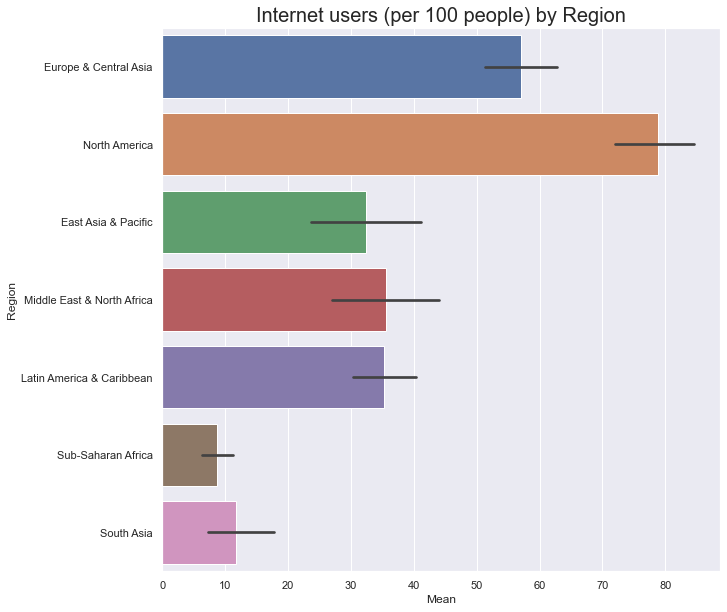

In [119]:
# The most common words within indicator
plt.figure(figsize=(10, 10))
sns.barplot(y="Region", x="Mean", data=data_sample_by_indicator)
plt.title("Internet users (per 100 people) by Region", size=20)
plt.show()

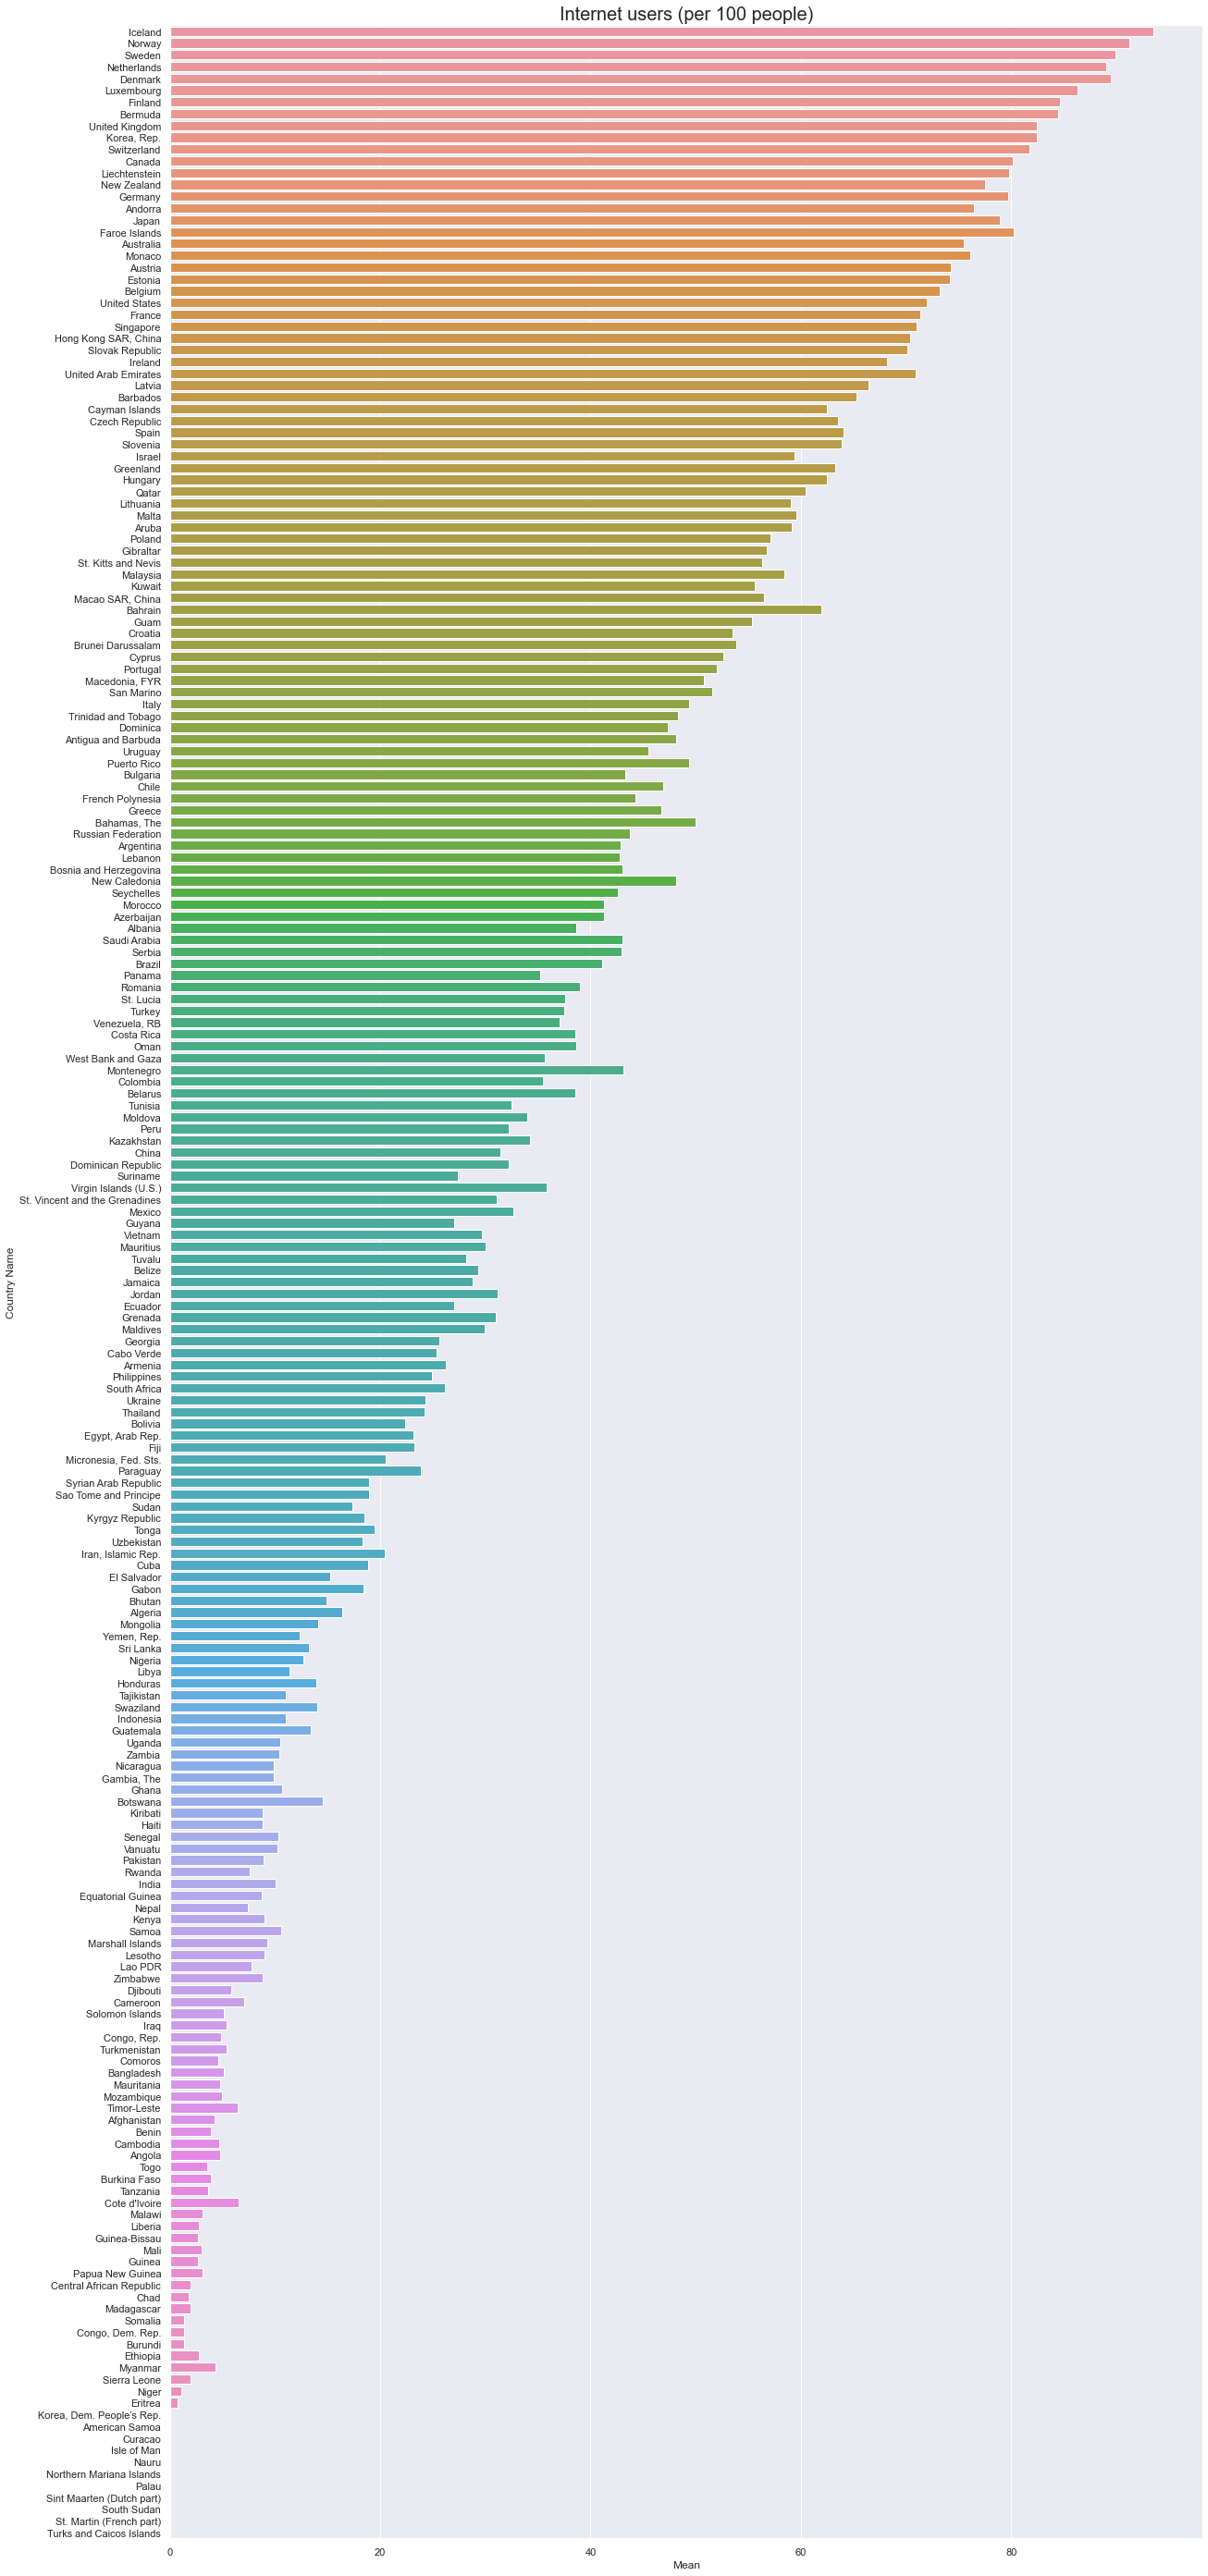

In [120]:
# The most common words within indicator
plt.figure(figsize=(20, 50))
sns.barplot(y="Country Name", x="Mean", data=data_sample_by_indicator)
plt.title("Internet users (per 100 people)", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.show()

In [121]:
data_sample_by_indicator = pd.DataFrame(data_sample[data_sample["Indicator Name"] == "Population, ages 15-24, total"]).reset_index(drop=True)
data_sample_by_indicator

Country Name Country Code                 Indicator Name  \
0              Afghanistan          AFG  Population, ages 15-24, total   
1                  Albania          ALB  Population, ages 15-24, total   
2                  Algeria          DZA  Population, ages 15-24, total   
3           American Samoa          ASM  Population, ages 15-24, total   
4                  Andorra          AND  Population, ages 15-24, total   
..                     ...          ...                            ...   
208  Virgin Islands (U.S.)          VIR  Population, ages 15-24, total   
209     West Bank and Gaza          PSE  Population, ages 15-24, total   
210            Yemen, Rep.          YEM  Population, ages 15-24, total   
211                 Zambia          ZMB  Population, ages 15-24, total   
212               Zimbabwe          ZWE  Population, ages 15-24, total   

        Indicator Code                      Region       Topic       2005  \
0    SP.POP.1524.TO.UN                  South Asia  Population  4910340.0   
1    SP.POP.1524.TO.UN       Europe & Central Asia  Population   586049.0   
2    SP.POP.1524.TO.UN  Middle East & North Africa  Population  7409807.0   
3    SP.POP.1524.TO.UN         East Asia & Pacific  Population        NaN   
4    SP.POP.1524.TO.UN       Europe & Central Asia  Population     8464.0   
..                 ...                         ...         ...        ...   
208  SP.POP.1524.TO.UN   Latin America & Caribbean  Population        NaN   
209  SP.POP.1524.TO.UN  Middle East & North Africa  Population   724827.0   
210  SP.POP.1524.TO.UN  Middle East & North Africa  Population  4547156.0   
211  SP.POP.1524.TO.UN          Sub-Saharan Africa  Population  2426399.0   
212  SP.POP.1524.TO.UN          Sub-Saharan Africa  Population  3266903.0   

          2006       2007       2008       2009       2010       2011  \
0    5134377.0  5367499.0  5606736.0  5848604.0  6090239.0  6330684.0   
1     594862.0   602317.0   607609.0   609841.0   608456.0   603104.0   
2    7434877.0  7433466.0  7403074.0  7340706.0  7245764.0  7118500.0   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4       8715.0        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
208        NaN        NaN        NaN        NaN        NaN        NaN   
209   754726.0   784867.0   815454.0   846859.0   879328.0   912717.0   
210  4718411.0  4887144.0  5051485.0  5209278.0  5359034.0  5500695.0   
211  2480394.0  2536697.0  2595464.0  2656713.0  2720387.0  2786411.0   
212  3309907.0  3342927.0  3366486.0  3381553.0  3389035.0  3389423.0   

          2012       2013       2014       2015  
0    6569239.0  6803785.0  7032072.0  7252785.0  
1     594101.0   582411.0   569427.0   556269.0  
2    6964424.0  6795040.0  6625398.0  6467818.0  
3          NaN        NaN        NaN        NaN  
4          NaN        NaN        NaN        NaN  
..         ...        ...        ...        ...  
208        NaN        NaN        NaN        NaN  
209   946780.0   981523.0  1016961.0  1053004.0  
210  5634854.0  5761692.0  5881653.0  5995687.0  
211  2854607.0  2924614.0  2995938.0  3068044.0  
212  3383141.0  3371070.0  3354236.0  3333716.0  

[213 rows x 17 columns]

In [122]:
data_sample_by_indicator["Mean"] = data_sample_by_indicator.mean(axis=1)
data_sample_by_indicator["Std"] = data_sample_by_indicator.std(axis=1)
data_sample_by_indicator["Median"] = data_sample_by_indicator.median(axis=1)
data_sample_by_indicator = data_sample_by_indicator.sort_values(by="Median", ascending=False)
data_sample_by_indicator

Country Name Country Code                 Indicator Name  \
86                      India          IND  Population, ages 15-24, total   
39                      China          CHN  Population, ages 15-24, total   
202             United States          USA  Population, ages 15-24, total   
87                  Indonesia          IDN  Population, ages 15-24, total   
144                  Pakistan          PAK  Population, ages 15-24, total   
..                        ...          ...                            ...   
173               South Sudan          SSD  Population, ages 15-24, total   
178  St. Martin (French part)          MAF  Population, ages 15-24, total   
196  Turks and Caicos Islands          TCA  Population, ages 15-24, total   
197                    Tuvalu          TUV  Population, ages 15-24, total   
208     Virgin Islands (U.S.)          VIR  Population, ages 15-24, total   

        Indicator Code                     Region       Topic         2005  \
86   SP.POP.1524.TO.UN                 South Asia  Population  218738389.0   
39   SP.POP.1524.TO.UN        East Asia & Pacific  Population  217382824.0   
202  SP.POP.1524.TO.UN              North America  Population   42759049.0   
87   SP.POP.1524.TO.UN        East Asia & Pacific  Population   42846073.0   
144  SP.POP.1524.TO.UN                 South Asia  Population   34979362.0   
..                 ...                        ...         ...          ...   
173  SP.POP.1524.TO.UN         Sub-Saharan Africa  Population          NaN   
178  SP.POP.1524.TO.UN  Latin America & Caribbean  Population          NaN   
196  SP.POP.1524.TO.UN  Latin America & Caribbean  Population          NaN   
197  SP.POP.1524.TO.UN        East Asia & Pacific  Population          NaN   
208  SP.POP.1524.TO.UN  Latin America & Caribbean  Population          NaN   

            2006         2007         2008         2009         2010  \
86   222224219.0  225700990.0  229076220.0  232225988.0  235056806.0   
39   220042486.0  221519350.0  221774704.0  220892800.0  218974009.0   
202   43388523.0   43962362.0   44459126.0   44855382.0   45137089.0   
87    42760972.0   42634693.0   42483570.0   42328040.0   42184439.0   
144   36044512.0   36977380.0   37764830.0   38397801.0   38872192.0   
..           ...          ...          ...          ...          ...   
173          NaN          NaN          NaN          NaN          NaN   
178          NaN          NaN          NaN          NaN          NaN   
196          NaN          NaN          NaN          NaN          NaN   
197          NaN          NaN          NaN          NaN          NaN   
208          NaN          NaN          NaN          NaN          NaN   

            2011         2012         2013         2014         2015  \
86   237548472.0  239713636.0  241535030.0  243002731.0  244120201.0   
39   215914397.0  211735888.0  206846521.0  201802535.0  197026759.0   
202   45296141.0   45343097.0   45307415.0   45230846.0   45147517.0   
87    42057105.0   41947672.0   41865701.0   41821108.0   41819264.0   
144   39187013.0   39348176.0   39370153.0   39273580.0   39080811.0   
..           ...          ...          ...          ...          ...   
173          NaN          NaN          NaN          NaN          NaN   
178          NaN          NaN          NaN          NaN          NaN   
196          NaN          NaN          NaN          NaN          NaN   
197          NaN          NaN          NaN          NaN          NaN   
208          NaN          NaN          NaN          NaN          NaN   

             Mean           Std        Median  
86   2.335402e+08  8.268909e+06  2.335402e+08  
39   2.139920e+08  8.168815e+06  2.159144e+08  
202  4.462605e+07  8.455449e+05  4.485538e+07  
87   4.224988e+07  3.661974e+05  4.218444e+07  
144  3.811780e+07  1.436840e+06  3.839780e+07  
..            ...           ...           ...  
173           NaN           NaN           NaN  
178           NaN           NaN          

In [123]:
# The most common words within indicator
plt.figure(figsize=(10, 10))
sns.barplot(y="Region", x="Mean", data=data_sample_by_indicator)
plt.title("Population, ages 15-24, total by Region", size=20)
plt.show()

In [124]:
# The most common words within indicator
plt.figure(figsize=(20, 50))
sns.barplot(y="Country Name", x="Mean", data=data_sample_by_indicator)
plt.title("Population, ages 15-24, total", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.show()